In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from io import StringIO
import re
from datetime import date
#from selenium import webdriver
#from selenium.webdriver.chrome.options import Options
from io import BytesIO
from zipfile import ZipFile
import os
from datetime import datetime, timedelta
from yahooquery import Ticker
import time
import random






import warnings
warnings.filterwarnings("ignore")


In [4]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
from io import BytesIO
from zipfile import ZipFile

# 配置：主 CSV 文件名，以及 JPX 页面和基础域名
MASTER_CSV = "option_master.csv"
BASE_URL = "https://www.jpx.co.jp"
INDEX_URL = "https://www.jpx.co.jp/markets/derivatives/option-price/index.html"

# 如果 ZIP 解压后的 CSV 没有表头，就用下面的中文列名顺序
COLUMN_NAMES = [
    "商品代码", "商品类型", "限月", "行权价格（円/ポイント）", "预留",
    # 看跌期权
    "看跌_合约代码", "看跌_收盘价", "看跌_预留", "看跌_理论价格", "看跌_IV",
    # 看涨期权
    "看涨_合约代码", "看涨_收盘价", "看涨_预留", "看涨_理论价格", "看涨_IV",
    # 标的收盘价 & 基准波动率
    "标的收盘价", "基准波动率"
]

def fetch_latest_option_data(existing_max_date):
    """
    抓取 JPX 页面上所有 ZIP 链接，筛选取引日 > existing_max_date 的文件，
    下载并解压 CSV（无表头），并为其指定中文列名，返回 DataFrame（包含所有商品类型）。
    """
    resp = requests.get(INDEX_URL)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    links = []
    for a in soup.find_all("a", href=True):
        href = a["href"]
        if href.lower().endswith(".zip"):
            parent_tr = a.find_parent("tr")
            if not parent_tr:
                continue
            tds = parent_tr.find_all("td")
            if not tds:
                continue
            date_text = tds[0].get_text(strip=True)
            try:
                date_obj = datetime.strptime(date_text, "%Y/%m/%d").date()
            except ValueError:
                continue
            full_url = href if href.startswith("http") else BASE_URL + href
            links.append((date_obj, full_url))

    new_links = [(d, url) for (d, url) in links if d > existing_max_date]
    if not new_links:
        return pd.DataFrame()

    data_frames = []
    for date_obj, zip_url in sorted(new_links):
        print(f"Downloading {zip_url} (交易日期: {date_obj}) ...")
        r = requests.get(zip_url)
        r.raise_for_status()
        with ZipFile(BytesIO(r.content)) as z:
            csv_names = [name for name in z.namelist() if name.lower().endswith(".csv")]
            if not csv_names:
                continue
            csv_name = csv_names[0]
            with z.open(csv_name) as csvfile:
                # 读取无表头 CSV，指定中文列名
                df = pd.read_csv(csvfile, encoding="shift_jis", header=None, names=COLUMN_NAMES, dtype=str)
                # 添加一列“交易日期”
                df["交易日期"] = date_obj
                data_frames.append(df)

    if not data_frames:
        return pd.DataFrame()

    return pd.concat(data_frames, ignore_index=True)

def update_master_csv():
    """
    更新本地的 option_master.csv：
    - 如果文件存在，读取最大“交易日期”，下载网页上大于该日期的 ZIP，解压并追加所有商品类型；
    - 如果文件不存在，则下载最新 ZIP 初始化并包含所有商品类型。
    """
    if os.path.exists(MASTER_CSV):
        master_df = pd.read_csv(MASTER_CSV, parse_dates=["交易日期"], encoding="shift_jis")
        existing_max_date = master_df["交易日期"].max().date()
        new_df = fetch_latest_option_data(existing_max_date)
        if new_df.empty:
            print("没有新数据。Master CSV 已是最新。")
            return
        combined = pd.concat([master_df, new_df], ignore_index=True)
        combined.drop_duplicates(
            subset=["交易日期", "限月", "行权价格（円/ポイント）", "商品类型"],
            keep="last",
            inplace=True
        )
        combined.sort_values(by=["交易日期", "限月", "行权价格（円/ポイント）"], inplace=True)
        combined.to_csv(MASTER_CSV, index=False, encoding="shift_jis")
        print(f"Master CSV 已更新。新增 {len(new_df)} 行，总行数：{len(combined)}。")
    else:
        new_df = fetch_latest_option_data(existing_max_date=datetime(1900,1,1).date())
        if new_df.empty:
            print("未从 JPX 页面获取到初始化数据。")
            return
        new_df.sort_values(by=["交易日期", "限月", "行权价格（円/ポイント）"], inplace=True)
        new_df.to_csv(MASTER_CSV, index=False, encoding="utf-8-sig")
        print(f"Master CSV 已初始化，共 {len(new_df)} 行。")

if __name__ == "__main__":
    update_master_csv()

Master CSV 已初始化，共 749548 行。


In [ ]:

# 请根据实际路径修改
MASTER_CSV_PATH = "option_master.csv"  # 或 "/mnt/data/option_master.csv"

# 1. 加载主文件
df_master = pd.read_csv(MASTER_CSV_PATH, encoding="utf-8-sig", parse_dates=["交易日期"])

# 2. 构建标准结构，包括 product_code 列
df_put = pd.DataFrame({
    "date": df_master["交易日期"],
    "contract_month": df_master["限月"],
    "strike": df_master["行权价格（円/ポイント）"],
    "underlying": df_master["标的收盘价"],
    "market_price": df_master["看跌_收盘价"],
    "theo_price": df_master["看跌_理论价格"],
    "iv_real": df_master["看跌_IV"],
    "option_type": "PUT",
    "product_code": df_master["商品代码"]
})

df_call = pd.DataFrame({
    "date": df_master["交易日期"],
    "contract_month": df_master["限月"],
    "strike": df_master["行权价格（円/ポイント）"],
    "underlying": df_master["标的收盘价"],
    "market_price": df_master["看涨_收盘价"],
    "theo_price": df_master["看涨_理论价格"],
    "iv_real": df_master["看涨_IV"],
    "option_type": "CALL",
    "product_code": df_master["商品代码"]
})

df_standard = pd.concat([df_put, df_call], ignore_index=True)

# 3. 225 主板 (NK225E) 与 225 mini (NK225MWE) 筛选
df_225 = df_standard[df_standard["product_code"].str.startswith("NK225E")]
df_225mini = df_standard[df_standard["product_code"].str.startswith("NK225MWE")]

# 4. 分别按类型拆分
df_225_call = df_225[df_225["option_type"] == "CALL"]
df_225_put  = df_225[df_225["option_type"] == "PUT"]
df_225mini_call = df_225mini[df_225mini["option_type"] == "CALL"]
df_225mini_put  = df_225mini[df_225mini["option_type"] == "PUT"]

# 5. 保存为 CSV
df_225_call.to_csv("NK225_call.csv", index=False, encoding="utf-8-sig")
df_225_put.to_csv("NK225_put.csv", index=False, encoding="utf-8-sig")
df_225mini_call.to_csv("NK225MWE_call.csv", index=False, encoding="utf-8-sig")
df_225mini_put.to_csv("NK225MWE_put.csv", index=False, encoding="utf-8-sig")


ModuleNotFoundError: No module named 'ace_tools'

In [23]:

# —— 配置 —— #
YEAR_CONFIG = {
    "2023": {
        "html": "https://www.jpx.co.jp/markets/statistics-derivatives/monthly-quotations/archives-2023.html",
        "json": None
    },
    "2024": {
        "html": "https://www.jpx.co.jp/markets/statistics-derivatives/monthly-quotations/archives-01.html",
        "json": "https://www.jpx.co.jp/automation/markets/statistics-derivatives/monthly_quotations/json/monthly_quotations_2024.json"
    },
    "2025": {
        "html": "https://www.jpx.co.jp/markets/statistics-derivatives/monthly-quotations/index.html",
        "json": "https://www.jpx.co.jp/automation/markets/statistics-derivatives/monthly_quotations/json/monthly_quotations_2025.json"
    },
}
MONTH_MAP = {
    "Jan":"01","Feb":"02","Mar":"03","Apr":"04",
    "May":"05","Jun":"06","Jul":"07","Aug":"08",
    "Sep":"09","Oct":"10","Nov":"11","Dec":"12"
}
# 25 列最终命名
FINAL_COLS = [
    "year_month","product_jp","option_type","flex_settlement","contract_month",
    "strike","open_date","open_price","open_jnet",
    "high_date","high_price","high_jnet",
    "low_date","low_price","low_jnet",
    "close_date","close_price","close_jnet",
    "avg_close_price","volume","trading_value",
    "exercised","open_interest","days_traded","last_trading_day"
]
OUTPUT = "hist_index_options_all.csv"
# —— 配置结束 —— #

def scrape_links():
    links = []
    base = "https://www.jpx.co.jp"
    pat_html = re.compile(r"SIOP_M_(\d{6})\.xlsx", re.IGNORECASE)
    pat_xlsx = re.compile(r"(\d{6})\.xlsx$", re.IGNORECASE)

    # 静态抓
    for year, cfg in YEAR_CONFIG.items():
        if cfg["html"]:
            print(f"[{year}] HTML 抓取")
            r = requests.get(cfg["html"]); r.raise_for_status()
            soup = BeautifulSoup(r.text, "html.parser")
            for a in soup.find_all("a", href=True):
                if pat_html.search(a["href"]):
                    ym = pat_html.search(a["href"]).group(1)
                    url = a["href"] if a["href"].startswith("http") else base + a["href"]
                    links.append((ym, url))

        # 静态无果，JSON 兜底
        if cfg["json"] and not any(l[0].startswith(year) for l in links):
            print(f"[{year}] JSON 兜底")
            r = requests.get(cfg["json"]); r.raise_for_status()
            data = r.json().get("TableDatas", [])
            for entry in data:
                for mth, mnum in MONTH_MAP.items():
                    link = entry.get(mth)
                    if link and link.endswith(".xlsx"):
                        ym = pat_xlsx.search(link).group(1)
                        full = link if link.startswith("http") else base + link
                        links.append((ym, full))

    # 去重按年月排序
    return sorted({(ym, url) for ym, url in links}, key=lambda x: x[0])

def download_all(links):
    raws = []
    for ym, url in links:
        print(f"下载 {ym} → {url}")
        r = requests.get(url); r.raise_for_status()
        # 不给 header，跳过前6行
        df0 = pd.read_excel(BytesIO(r.content), engine="openpyxl",
                            header=None, skiprows=6)
        # 在原表最后加年月列
        df0["year_month"] = ym
        raws.append(df0)
    return pd.concat(raws, ignore_index=True)


def main():
    # 1) 抓取所有候选链接（HTML + JSON 兜底）
    links = scrape_links()

    # 2) **只保留文件名里带 "SIOP" 的**，其余忽略
    links = [
        (ym, url) for ym, url in links
        if "SIOP" in os.path.basename(url).upper()
    ]
    print(f"过滤后，剩余 {len(links)} 个 SIOP 文件。")

    if not links:
        print("⚠️ 没有找到任何 SIOP 文件，程序退出。")
        return

    # 3) 下载（只会下载上面筛出来的 SIOP 文件）
    raw = download_all(links)

    # 4) 其余部分先不动，之后再给它随便插个列名就行
    #    比如直接：
    raw.to_csv("raw_siop_concat.csv", index=False, encoding="utf-8-sig")
    print("已将原始合并结果输出到 raw_siop_concat.csv")

if __name__ == "__main__":
    main()

[2023] HTML 抓取
[2024] HTML 抓取
[2024] JSON 兜底
[2025] HTML 抓取
[2025] JSON 兜底
过滤后，剩余 29 个 SIOP 文件。
下载 202301 → https://www.jpx.co.jp/markets/statistics-derivatives/monthly-quotations/fi1l5r0000001l53-att/SIOP_M_202301.xlsx
下载 202302 → https://www.jpx.co.jp/markets/statistics-derivatives/monthly-quotations/cg27su000000281w-att/SIOP_M_202302.xlsx
下载 202303 → https://www.jpx.co.jp/markets/statistics-derivatives/monthly-quotations/cg27su0000004hx5-att/SIOP_M_202303.xlsx
下载 202304 → https://www.jpx.co.jp/markets/statistics-derivatives/monthly-quotations/cg27su0000006gl7-att/SIOP_M_202304.xlsx
下载 202305 → https://www.jpx.co.jp/markets/statistics-derivatives/monthly-quotations/cg27su0000008ys8-att/SIOP_M_202305.xlsx
下载 202306 → https://www.jpx.co.jp/markets/statistics-derivatives/monthly-quotations/aocfb40000001xdx-att/SIOP_M_202306.xlsx
下载 202307 → https://www.jpx.co.jp/markets/statistics-derivatives/monthly-quotations/aocfb40000003v4e-att/SIOP_M_202307.xlsx
下载 202308 → https://www.jpx.co.jp/ma

In [2]:
# 1) 读取你刚才合并好的 CSV
df = pd.read_csv("raw_siop_concat.csv", dtype=str)
# 2) 删除列名为 '4' 和 '25' 的垃圾列
cols_to_drop = [c for c in ['4', '25'] if c in df.columns]
df = df.drop(columns=cols_to_drop)
# 3) 删除最后一列
df.drop(columns=[df.columns[-1]], inplace=True)
# 4) 先把所有单个字符 “－” 或 "-"（中英文短横）替换为 np.nan
df = df.replace({"－": np.nan, "-": np.nan})


,year_month,product_jp,product_id,option_type,contract_month,strike,open_date,open_price,high_date,high_price,...,close_price,avg_close_price,volume,volume_jnet,trading_value,trading_value_jnet,exercised,open_interest,days_traded,last_trading_day
0,Jan-23,日経225オプション,Nikkei 225 Options,P,Jan-23,10000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1080,NaN,2023/01/12
1,Jan-23,日経225オプション,Nikkei 225 Options,P,Jan-23,11000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,366,NaN,2023/01/12
2,Jan-23,日経225オプション,Nikkei 225 Options,P,Jan-23,12000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,474,NaN,2023/01/12
3,Jan-23,日経225オプション,Nikkei 225 Options,P,Jan-23,13000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,594,NaN,2023/01/12
4,Jan-23,日経225オプション,Nikkei 225 Options,P,Jan-23,14000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741,NaN,2023/01/12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68202,May-25,TOPIXオプション,TOPIX Options,C,Dec-28,2600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400,NaN,2028/12/07
68203,May-25,TOPIXオプション,TOPIX Options,C,Dec-28,2700,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350,NaN,2028/12/07
68204,May-25,TOPIXオプション,TOPIX Options,C,Dec-28,3050,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400,NaN,2028/12/07
68205,May-25,TOPIXオプション,TOPIX Options,C,Dec-28,3400,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250,NaN,2028/12/07


In [3]:

# 1. 读取期货 Excel 数据（日中日足）
fut_df = pd.read_excel("N225minif_2025.xlsx", sheet_name="日中日足")
fut_df.columns = ["date", "open", "high", "low", "close", "volume"]
fut_df["date"] = pd.to_datetime(fut_df["date"], format="%Y/%m/%d")
fut_df = fut_df[["date", "close"]].rename(columns={"close": "underlying"})

# 2. 处理期权数据 df
MONTH_MAP = {
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
    'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
    'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}

# 拆分 year_month
ym_split = df['year_month'].str.split('-', expand=True)
df['month_abbr'] = ym_split[0]
df['year_suffix'] = ym_split[1].astype(int)

# 构造年月日
df['year'] = 2000 + df['year_suffix']
df['month'] = df['month_abbr'].map(MONTH_MAP)
df['day'] = df['close_date'].str.zfill(2)

# 合成日期并转为 datetime
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' +
                            df['month'] + '-' +
                            df['day'],
                            format='%Y-%m-%d')

# 3. 合并期货数据
df = df.merge(fut_df, on='date', how='left')

# 4. 处理 market_price, theo_price, iv_real
df['theo_price'] = pd.NA
df['iv_real']    = pd.NA
df['market_price'] = pd.to_numeric(df['close_price'], errors='coerce')

# 5. option type & product code 映射
df['option_type'] = df['option_type'].map({'C': 'CALL', 'P': 'PUT'})
prod_map = {
    "Nikkei 225 Options": "NK225E",
    "Nikkei 225 mini Options": "NK225M"
}
df['product_code'] = df['product_id'].map(prod_map)

# 6. 构建标准化表
std = df[
    ['date', 'contract_month', 'strike', 'underlying',
     'market_price', 'theo_price', 'iv_real',
     'option_type', 'product_code']
].copy()

# 7. 拆分输出为 4 个 CSV
for (pname, pcode) in prod_map.items():
    for ot in ['CALL', 'PUT']:
        sub = std[(df['product_id'] == pname) & (std['option_type'] == ot)]
        if not sub.empty:
            fname = f"{pcode}_{ot.lower()}_noniv.csv"
            sub.sort_values('date').to_csv(fname, index=False, encoding="utf-8-sig")
            print(f"输出 {fname}：{len(sub)} 行")


输出 NK225E_call_noniv.csv：17558 行
输出 NK225E_put_noniv.csv：23793 行
输出 NK225M_call_noniv.csv：8828 行
输出 NK225M_put_noniv.csv：9934 行


# 日经期货 Covered Call “期货腿”总体思路

下面以最通俗的方式介绍“期货多头＋卖出看涨期权”（Covered Call）套利中，**期货腿**的总体思路、关键术语和应对各种市场情况。最后附上一个简单的 ASCII 流程图，帮助你快速抓住核心。

---

## 一、总体思路

1. **策略目标**  
   - 通过“买入日经225期货多头”＋“同日卖出等 Delta 的看涨期权”，力图用期权端挣到的时间价值补偿期货腿的风险波动。  
   - 期货多头主要用来对冲期权的 Δ（Delta）敞口，理论上把大部分方向性风险中和，只赚取“隐含波动率 > 实际波动率”之间的差值。

2. **两大核心环节**  
   1. **择时买入期货（期货腿）**  
      - 只有在“趋势向上、短期动能强、波动适中、流动性充足”时才做多。  
      - 给自己留出一个“止损点”，一旦期货价格跌破该点就平仓（买回期权同时平掉期货），控制最大亏损。  
   2. **同日卖出看涨期权（期权腿）**  
      - 卖出一个月左右到期、轻度或适度虚值的看涨期权，赚取权利金。  
      - 每笔期权交易都要配合期货腿做 Δ 对冲（通常以当天的 Delta → 买入等量的期货），并在持仓期内动态监控 Delta、Gamma、Vega 等风险。

3. **为什么要这样做？**  
   - **期货腿**负责锁定方向性（如果市场上涨，期货赚钱；下跌则亏损）；  
   - **期权腿**负责赚取“卖权利金”（若波动较小、期权隐含波动高，就能赚到溢价）；  
   - 当隐含波动（IV）持续大于未来实际波动（RV）时，卖期权的收益会超过期货腿的亏损 → 整体组合可以正向获利。

---

## 二、关键术语 & 指标

以下术语会频繁出现，请先理解它们的含义和作用：

1. **MA（移动均线，Moving Average）**  
   - 计算方式：将过去 N 天的收盘价求平均。  
   - 作用：表示“过去 N 天收盘价的平滑曲线”，常见的 N=20（约一个月）。  
   - 交易意义：  
     - `收盘价 > MA20` → 中期趋势向上，可优先做多；  
     - `收盘价 < MA20` → 中期趋势偏弱，需谨慎或空仓。

2. **Mom（动量，Momentum）**  
   - 计算方式：过去 M 天的涨跌幅（`今日收盘 ÷ M 天前收盘 − 1`），常见 M=5（约一周）。  
   - 作用：表示“短期内价格的涨跌力度”，Mom5 > 0 说明过去一周整体上涨。  
   - 交易意义：  
     - `Mom5 > 0` 且 `收盘价 > MA20` → 趋势＋动能都偏多，做多信号更强；  
     - `Mom5 < 0` → 短期动能偏空，谨慎做多。

3. **ATR（平均真实波幅，Average True Range）**  
   - 计算方式：  
     1. 当日真实波幅 TR = max(当日最高−当日最低, 当日最高−昨收, 当日最低−昨收)；  
     2. 对过去 P 天的 TR 做简单平均，得到 `ATR_P`。  
   - 常用参数：  
     - `ATR14`（过去 14 天）称为“短期 ATR”，衡量 2 周内的平均波动；  
     - `ATR60`（过去 60 天）称为“长期 ATR”，衡量 3 个月内的平均波动。  
   - 交易意义：  
     - **ATR14** 用来 **设止损距离**：`止损价 = 入场价 − k × ATR14`，k 可调（如 1.0、1.2）。  
     - **ATR14 vs ATR60** 用作 **波动过滤**：  
       - 若 `ATR14 < ATR60 × atr_filter_ratio`（默认比例 = 1），说明“当前波动低于历史平均”，更适合在波动放大前进场。

4. **流动性（Volume / Open Interest）**  
   - **成交量 (Volume)**：当日买卖合约总量，衡量活跃度。通常要 `Volume ≥ vol_threshold`（如 2 万手）才能进场。  
   - **持仓量 (Open Interest)**：当日所有未平仓合约总量，也衡量“市场参与热度”。通常要 `Open Interest ≥ oi_threshold`（如 1 万手）以上。

5. **Delta / Gamma / Vega（期权风险指标）**  
   - **Delta**：期权价格对标的价格变动的敏感度。卖看涨期权后，需在期货腿多买入等量 Delta（如 Δ=0.3，则买 0.3 张期货）来对冲。  
   - **Gamma**：衡量 Delta 对标的价格二阶敏感度，即“Delta 会如何因价格变化而变化”。Gamma 大时，Delta 变化迅速，需要更频繁地对冲。  
   - **Vega**：衡量期权价格对隐含波动率变化的敏感度。一旦隐含波动（IV）暴涨，你卖空的期权会立刻亏损，期货对冲无法弥补这部分收支。

---

## 三、各类市场情况与对应策略

以下几种常见行情情况，以及我们在“期货腿”上对应的做法：

1. **趋势向上 + 动量强 + 波动适中（ATR14 < ATR60）+ 流动性好**  
   - **做法**：  
     1. 当日收盘满足：`收盘 > MA20` 且 `Mom5 > 0`，并且 `ATR14 < ATR60`、`Volume ≥ vol_threshold`、`OI ≥ oi_threshold` → 发出“入场信号(can_enter = True)”。  
     2. **收盘价看多、买入期货多头**，同时**卖出相应 Delta 的看涨期权**。  
     3. 设置止损价（默认为 `入场价 − 1×ATR14`），并挂限价止损单。  

2. **趋势向上但波动已经很大（ATR14 ≥ ATR60×ratio）**  
   - **做法**：  
     - 暂时**不入场**，因为市场波动已经偏大，风险不易控制。  
     - 等待短期波动回落（ATR14 再次下降到 ATR60 之下）或趋势更稳固时再考虑入场。  

3. **趋势向下（收盘 ≤ MA20）或短期动量为负（Mom5 ≤ 0）**  
   - **做法**：  
     - 不做多、不卖 Covered Call，可以考虑空一部分期货但需与空看跌期权或买入看跌期权对冲（非本策略范围）。  
     - “期货腿”此时保持空仓，等待趋势向上再介入。

4. **触发止损（收盘 ≤ 止损价）**  
   - **做法**：  
     1. 当日收盘价如果跌破 `止损价 = 入场价 − k×ATR14`（或百分比止损），立即**平掉期货多头 + 买回期权**。  
     2. 记录“止损平仓日”和“止损价”，结束本次持仓。  
     3. 之后需要等待满足新一轮“入场条件”时再做下一笔。

5. **隔夜或重要事件**  
   - 若不打算隔夜持仓：**收盘前必须平仓**，避免夜间跳空风险。  
   - 若要隔夜持仓：需留足保证金，并预先在止损价附近挂好“限价止损单”；一旦夜盘行情剧烈跳空，自动平仓减少损失。  

6. **隐含波动骤升（Vega 风险）**  
   - 若卖出期权后，突发利空消息导致 IV 暴涨，卖空期权价值会大幅上涨，期货对冲无法抵消这部分亏损：  
     - **做法**：一旦检测到“当天 IV 大涨 > 阈值”（比如暴涨 5%以上），就要**立即买回期权 + 平仓期货**，把风险止住。  

---

## 四、简易流程图（ASCII）

下面的流程图展示了“期货腿”从“检测入场到止损离场”这一段最关键的逻辑：



In [ ]:
def fetch_continuous_futures_yq(symbol="NIY=F", start="2023-01-01", end="2025-06-09", max_retries=5):
    """
    使用 yahooquery 拉取日经225期货连续合约日线数据，带重试与退避。
    返回 DataFrame，索引为日期，列 ['open','high','low','close','volume'].
    """
    for attempt in range(1, max_retries+1):
        try:
            tkr = Ticker(symbol, asynchronous=True)
            df = tkr.history(start=start, end=end)
            df_sym = df.xs(symbol, level=0)
            break
        except Exception as e:
            if attempt == max_retries:
                raise
            backoff = (2 ** (attempt-1)) + random.random()
            print(f"尝试{attempt}失败：{e}，{backoff:.1f}s后重试")
            time.sleep(backoff)
    df_sym.index = pd.to_datetime(df_sym.index)
    df_sym = df_sym.sort_index()
    df_cont = pd.DataFrame({
        'front_open':   df_sym['open'],
        'front_high':   df_sym['high'],
        'front_low':    df_sym['low'],
        'front_settle': df_sym['close'],
        'front_volume': df_sym['volume'],
    }, index=df_sym.index)
    return df_cont

def update_futures_csv(symbol="NIY=F", csv_path="futures.csv", default_start="2022-06-09", end=None):
    """
    如果 csv_path 存在，则只抓取最新日期之后的数据；否则从 default_start 全量抓取，
    并保存到 csv_path。
    返回更新后的 DataFrame，包含 date 列。
    """
    # 确定 end 日期
    end = end or datetime.today().strftime("%Y-%m-%d")
    # 检查现有文件
    if os.path.exists(csv_path):
        df_exist = pd.read_csv(csv_path, parse_dates=['date'], index_col='date')
        last_date = df_exist.index.max()
        start_date = (last_date + timedelta(days=1)).strftime("%Y-%m-%d")
    else:
        df_exist = None
        start_date = default_start

    # 如果 start_date > end, 无需更新
    if pd.to_datetime(start_date) > pd.to_datetime(end):
        print("已是最新，无需更新。")
        return df_exist.reset_index()

    print(f"抓取 {symbol} 从 {start_date} 到 {end} 的数据…")
    df_new = fetch_continuous_futures_yq(symbol, start=start_date, end=end)
    df_new.index.name = 'date'
    df_new = df_new.reset_index()

    if df_exist is not None and not df_exist.empty:
        df_exist = df_exist.reset_index()
        df_all = pd.concat([df_exist, df_new], ignore_index=True)
    else:
        df_all = df_new

    # 保存
    df_all.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"已保存 {len(df_all)} 行到 {csv_path}")
    return df_all

# ------------------------------
# 2. 技术指标计算
# ------------------------------

def compute_indicators(df_cont, 
                       ma_window=60, mom_period=5, 
                       atr_window_short=14, atr_window_long=60):
    """
    在 df_cont 基础上计算:
    - MA (ma_window)
    - Mom (mom_period)
    - ATR_short (atr_window_short)
    - ATR_long (atr_window_long)
    返回 df_ind，含新增列 ['MA','Mom','ATR_short','ATR_long'].
    """
    df = df_cont.copy()
    df['MA'] = df['front_settle'].rolling(window=ma_window, min_periods=ma_window).mean()
    df['Mom'] = df['front_settle'].pct_change(periods=mom_period)
    
    high = df['front_high']
    low = df['front_low']
    prev_close = df['front_settle'].shift(1)
    tr1 = (high - low).abs()
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    df['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    df['ATR_short'] = df['TR'].rolling(window=atr_window_short, min_periods=atr_window_short).mean()
    df['ATR_long'] = df['TR'].rolling(window=atr_window_long, min_periods=atr_window_long).mean()
    return df

# ------------------------------
# 3. 生成入场与止损信号
# ------------------------------

def generate_signals(df_ind,
                     vol_threshold=20000, 
                     atr_filter_ratio=1.0, 
                     stop_loss_multiplier=1.0, pct_stop_loss=None):
    """
    在带有指标的 df_ind 上生成：
    - can_enter: 满足入场条件
    - entry_price, stop_loss_price
    - exit_price (当止损触发)
    可调参数：
    - vol_threshold: 流动性过滤阈值
    - atr_filter_ratio: ATR_short < ATR_long * atr_filter_ratio
    - iv_rv_ratio: 可选，若提供则需 IV_today / RV_today > iv_rv_ratio ，此处简化暂不实现
    - stop_loss_multiplier: ATR 模式下的止损倍数
    - pct_stop_loss: 百分比止损 (若提供，则当 settle <= entry*(1 - pct_stop_loss) 时止损)
    """
    df = df_ind.copy()
    df['can_enter'] = False
    
    # 入场条件: 趋势、动量、波动过滤、流动性
    df.loc[
        (df['front_settle'] > df['MA']) &
        (df['Mom'] > 0) &
        (df['ATR_short'] < df['ATR_long'] * atr_filter_ratio) &
        (df['front_volume'] > vol_threshold),
        'can_enter'
    ] = True
    
    df['entry_price'] = np.nan
    df['stop_loss_price'] = np.nan
    df['exit_price'] = np.nan
    
    in_position = False
    entry_atr = None
    entry_price = None
    
    for date, row in df.iterrows():
        if not in_position:
            if row['can_enter']:
                in_position = True
                entry_price = row['front_settle']
                entry_atr = row['ATR_short']
                df.at[date, 'entry_price'] = entry_price
                if pct_stop_loss is not None:
                    df.at[date, 'stop_loss_price'] = entry_price * (1 - pct_stop_loss)
                else:
                    df.at[date, 'stop_loss_price'] = entry_price - stop_loss_multiplier * entry_atr
        else:
            sl = df.loc[:date, 'stop_loss_price'].dropna().iloc[-1]
            if row['front_settle'] <= sl:
                # 止损触发，平仓
                in_position = False
                df.at[date, 'exit_price'] = row['front_settle']
                entry_price = None
                entry_atr = None
            # 不触发止损则继续持仓
    return df

# ------------------------------
# 4. 可视化
# ------------------------------

def plot_signals(df_signals):
    """
    可视化价格与进出场点：
    - 收盘价曲线
    - 用绿色上箭头标记入场日
    - 用红色下箭头标记止损/平仓日
    """
    plt.figure(figsize=(14, 6))
    plt.plot(df_signals.index, df_signals['front_settle'], label='Close Price', color='blue')
    
    entries = df_signals[df_signals['entry_price'].notna()]
    exits = df_signals[df_signals['exit_price'].notna()]
    
    plt.scatter(entries.index, entries['entry_price'], marker='^', color='green', s=100, label='Entry')
    plt.scatter(exits.index, exits['exit_price'], marker='v', color='red', s=100, label='Exit')
    
    plt.title('Futures Price with Entry and Exit Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

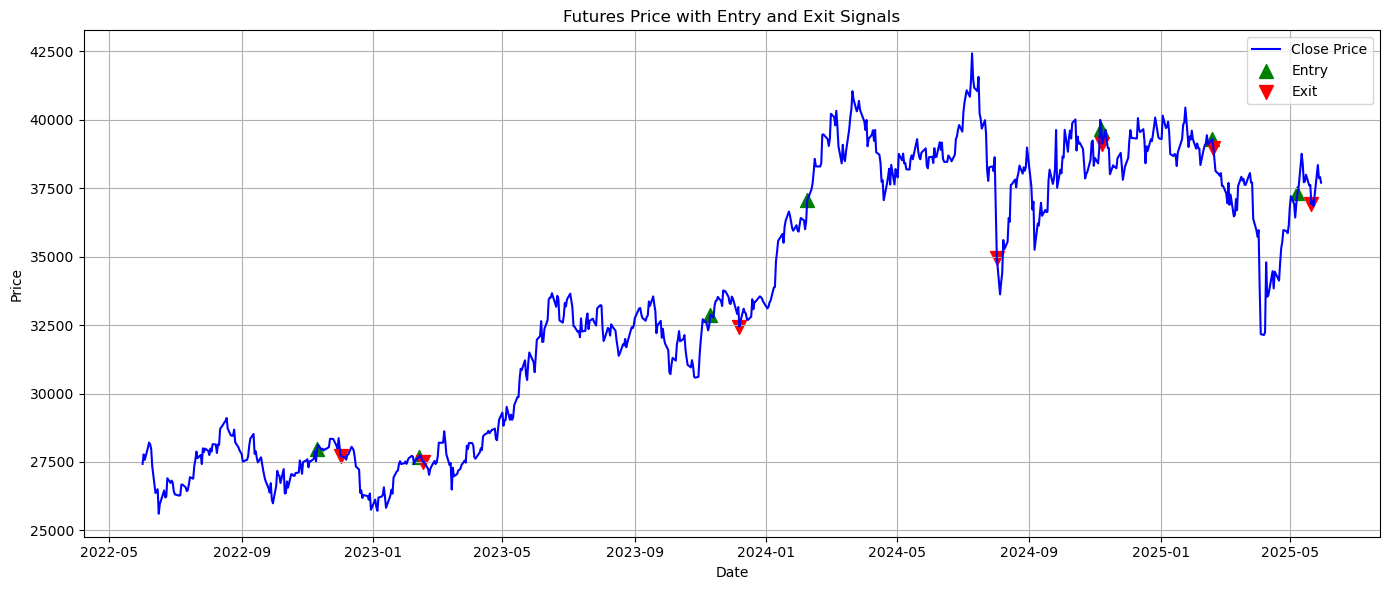

,front_settle,MA,Mom,ATR_short,ATR_long,can_enter,entry_price,stop_loss_price,exit_price
date,,,,,,,,,
2025-05-02,37210.0,34659.95,0.037646,412.500000,592.817643,False,NaN,NaN,NaN
2025-05-05,36925.0,34897.70,0.021580,385.714286,597.317643,False,NaN,NaN,NaN
2025-05-06,36430.0,35112.20,-0.010861,405.000000,595.484310,False,NaN,NaN,NaN
2025-05-07,36925.0,35346.45,-0.007659,395.357143,594.234310,False,NaN,NaN,NaN
2025-05-08,37319.0,35472.65,0.010670,379.571429,598.217643,True,37319.0,36939.428571,NaN
2025-05-09,37470.0,35669.20,0.028548,384.571429,603.884310,True,NaN,NaN,NaN
2025-05-12,38760.0,35927.95,0.049695,433.857143,621.266667,True,NaN,NaN,NaN
2025-05-13,38370.0,36134.20,0.028163,448.857143,623.850000,True,NaN,NaN,NaN
2025-05-14,37720.0,36296.70,0.006672,488.857143,628.683333,True,NaN,NaN,NaN


In [25]:
# ------------------------------
# 5. 示例调用与可视化展示
# ------------------------------

# 拉取数据
#df_cont = fetch_continuous_futures()
# 计算指标
# 2. 计算技术指标
df_ind = compute_indicators(df_cont,
                            ma_window=20,
                            mom_period=3,
                            atr_window_short=14,
                            atr_window_long=60)
# 生成信号（参数可调）
df_signals = generate_signals(
    df_ind,
    vol_threshold=20000,
    atr_filter_ratio=1.0,
    stop_loss_multiplier=1.0,
    pct_stop_loss=None
)
# 向下填充 Entry 和 Stop-Loss 用于持仓期间参考
df_signals['entry_price_ffill'] = df_signals['entry_price'].ffill()
df_signals['stop_loss_price_ffill'] = df_signals['stop_loss_price'].ffill()

# 可视化
plot_signals(df_signals)

# 展示部分信号示例
df_signals[['front_settle','MA','Mom','ATR_short','ATR_long','can_enter','entry_price','stop_loss_price','exit_price']].dropna(subset=['MA']).tail(20)

In [20]:
def build_df_cont_from_yf(df_yf: pd.DataFrame) -> pd.DataFrame:

    """
    输入：yfinance 拉取到的 DataFrame df_yf，索引为 MultiIndex(symbol, date)，
          列 ['open','high','low','close','volume','adjclose']。
    输出：单层索引的 df_cont，日期为索引，列为：
          ['front_open','front_high','front_low','front_settle','front_volume']
          
    """
    # 1) 如果 index 是 MultiIndex，先取出 symbol="NIY=F" 的部分；否则直接当 df_yf 用
    if isinstance(df_yf.index, pd.MultiIndex):
        # 假设第一层 index 名称是 'symbol'
        # 有两种常见写法：.xs 或者 .loc
        # 我们这里用 .xs 来提取第一层为 "NIY=F" 的子表
        df_sym = df_yf.xs("NIY=F", level=0).copy()
    else:
        # 如果没有多重索引，就直接把 df_yf 当作目标（但本例里应该是 MultiIndex）
        df_sym = df_yf.copy()

    # 2) 确保索引是 DatetimeIndex（如果被当成字符串），并按日期排序
    if not pd.api.types.is_datetime64_any_dtype(df_sym.index):
        df_sym.index = pd.to_datetime(df_sym.index)
    df_sym = df_sym.sort_index()

    # 3) 把需要的列重命名为前面例子中用的列名：
    #    yfinance 的 'open','high','low','close','volume' → 对应 'front_open','front_high',…
    df_cont = pd.DataFrame({
        'front_open':   df_sym['open'],
        'front_high':   df_sym['high'],
        'front_low':    df_sym['low'],
        'front_settle': df_sym['close'],
        'front_volume': df_sym['volume'],
        # 这里 yfinance 没有持仓量（Open Interest），所以先填 NaN 或 0，后续若有券商接口可补充
    }, index=df_sym.index)

    return df_cont
# 之前示例里定义的两个函数（不必再改动）：
def compute_futures_indicators(df_cont: pd.DataFrame) -> pd.DataFrame:
    df = df_cont.copy()
    # 1) MA20
    df['MA20'] = df['front_settle'].rolling(window=20, min_periods=20).mean()
    # 2) 5 日动量
    df['Mom5'] = df['front_settle'].pct_change(periods=5)
    # 3) True Range 及 ATR
    high = df['front_high']
    low  = df['front_low']
    prev_close = df['front_settle'].shift(1)
    tr1 = (high - low).abs()
    tr2 = (high - prev_close).abs()
    tr3 = (low  - prev_close).abs()
    df['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['ATR14'] = df['TR'].rolling(window=14, min_periods=14).mean()
    df['ATR60'] = df['TR'].rolling(window=60, min_periods=60).mean()
    return df
def generate_entry_stop_signals(df_ind: pd.DataFrame,
                                volume_threshold: float = 20000,
                                atr_multiplier: float = 1.0) -> pd.DataFrame:
    df = df_ind.copy()
    # 1) 生成 can_enter
    df['can_enter'] = False
    df.loc[
        (df['front_settle'] > df['MA20']) &
        (df['Mom5'] > 0) &
        (df['ATR14'] < df['ATR60']) &
        (df['front_volume'] > volume_threshold),
        'can_enter'
    ] = True

    # 2) 初始化 entry_price 与 stop_loss_price
    df['entry_price'] = np.nan
    df['stop_loss_price'] = np.nan

    in_position = False
    entry_atr14 = None

    # 3) 遍历每个交易日，做开仓/止损判断
    for idx, row in df.iterrows():
        if not in_position:
            # 如果当前未持仓，且当天 can_enter 为 True，就记为开仓
            if row['can_enter']:
                in_position = True
                entry_price = row['front_settle']  # 也可改成 row['front_open']
                entry_atr14 = row['ATR14']
                df.at[idx, 'entry_price'] = entry_price
                df.at[idx, 'stop_loss_price'] = entry_price - atr_multiplier * entry_atr14
            else:
                continue
        else:
            # 如果已经持仓，要看是否触发止损
            last_sl = df.loc[:idx, 'stop_loss_price'].dropna().iloc[-1]
            if row['front_settle'] <= last_sl:
                # 触发止损，结束持仓
                in_position = False
                entry_atr14 = None
                # 注意：当日止损后不立刻再开新仓，除非下一行里 can_enter 又变 True
            else:
                continue

    return df
# ============================================================
# —— 整体运行示例 —— （假设 df_yf 已经由 yfinance 拉好）
# ============================================================

# 例如你通过 yfinance 得到 df_yf：
#

#tk = Ticker("NIY=F")
#df_all = tk.history(start="2022-06-01", end="2025-06-01", interval="1d")
# 1) 把 yfinance 的 df_yf 转成 df_cont
df_cont = build_df_cont_from_yf(df_all)

# 2) 在 df_cont 基础上计算技术指标
df_ind = compute_futures_indicators(df_cont)

# 3) 生成入场/止损信号
#    这里演示的阈值只是示例，你可以根据日经期货的日均“成交量”和“持仓量”自行微调
df_signals = generate_entry_stop_signals(df_ind,
                                         volume_threshold=20000,  # 例如最低成交量 2 万    
                                         atr_multiplier=1.0)

# 4) 把 entry_price 和 stop_loss_price 向下填充，便于在持仓期随时读取入场与止损价
df_signals['entry_price_ffill'] = df_signals['entry_price'].ffill()
df_signals['stop_loss_price_ffill'] = df_signals['stop_loss_price'].ffill()

# 5) 简单看一下几行结果，验证入场/止损是否符合预期
cols_to_show = [
    'front_settle',
    'MA20', 'Mom5', 'ATR14', 'ATR60',
    'can_enter', 'entry_price', 'stop_loss_price',
    'entry_price_ffill', 'stop_loss_price_ffill'
]
print(df_signals[cols_to_show].dropna(subset=['MA20']).tail(20))


            front_settle      MA20      Mom5       ATR14       ATR60  \
date                                                                   
2025-05-02       37210.0  34659.95  0.034329  412.500000  592.817643   
2025-05-05       36925.0  34897.70  0.027550  385.714286  597.317643   
2025-05-06       36430.0  35112.20  0.015895  405.000000  595.484310   
2025-05-07       36925.0  35346.45  0.021580  395.357143  594.234310   
2025-05-08       37319.0  35472.65  0.013277  379.571429  598.217643   
2025-05-09       37470.0  35669.20  0.006987  384.571429  603.884310   
2025-05-12       38760.0  35927.95  0.049695  433.857143  621.266667   
2025-05-13       38370.0  36134.20  0.053253  448.857143  623.850000   
2025-05-14       37720.0  36296.70  0.021530  488.857143  628.683333   
2025-05-15       37755.0  36492.45  0.011683  478.857143  623.683333   
2025-05-16       37995.0  36669.45  0.014011  512.785714  622.350000   
2025-05-19       37605.0  36843.45 -0.029799  561.000000  621.26

In [28]:
# --- Module: Fetch Futures Data via Selenium ---
def fetch_jpx_future_quotes(disptype: str, targets=None) -> pd.DataFrame:
    """
    抓取并过滤 JPX 先物价格信息（迷你日経225及标准日経225）。
    disptype: 'day_through'（日通し）、'daytime'（日中）、'night'（夜間）
    targets: list of contract_type to keep, e.g. ['日経225先物', '日経225mini']
    返回包含以下字段的 DataFrame:
      ['contract_type','contract_month','trade_date',
       'open_price','high_price','low_price','last_price',
       'change','volume_value','ask_price','ask_size',
       'bid_price','bid_size','settlement_price',
       'limit_upper','limit_lower','open_interest','session']
    """
    url = f"https://port.jpx.co.jp/jpxhp/main/index.aspx?f=future&disptype={disptype}"

    # 启动无头浏览器
    opts = Options()
    opts.add_argument("--headless")
    driver = webdriver.Chrome(options=opts)
    driver.get(url)
    driver.implicitly_wait(5)

    # 获取渲染后的表格 HTML
    table = driver.find_element("css selector", "table.tbl-s2")
    html = table.get_attribute("outerHTML")
    driver.quit()

    # 用 pandas 解析 HTML
    df = pd.read_html(html)[0]
    df.columns = [
        'contract_type', 'contract_month', 'trade_date',
        'open_price', 'high_price', 'low_price', 'last_price',
        'change', 'volume_value', 'ask_price', 'ask_size',
        'bid_price', 'bid_size', 'settlement_price', 'limit_range', 'open_interest'
    ]

    # 只保留目标合约
    if targets is not None:
        df = df[df['contract_type'].isin(targets)].reset_index(drop=True)

    # 按空白字符安全拆分限价范围，如 "40,990  34,930"
    limits = df['limit_range'].astype(str).str.split(r'\s+', expand=True)
    df['limit_upper'] = limits[0].str.replace(',', '').astype(float)
    df['limit_lower'] = limits[1].str.replace(',', '').astype(float)
    df = df.drop(columns=['limit_range'])

    # 转换日期
    df['trade_date'] = pd.to_datetime(df['trade_date'], format='%m/%d').apply(
        lambda dt: dt.replace(year=pd.Timestamp.now().year)
    )

    # 转换数值列：先提取数字部分，再转换
    num_cols = [
        'open_price','high_price','low_price','last_price',
        'change','volume_value','ask_price','ask_size',
        'bid_price','bid_size','settlement_price',
        'limit_upper','limit_lower','open_interest'
    ]
    for col in num_cols:
        # 提取字符串中的首个数字或带千分位的部分
        # 例如 "38,000 (05/30) (17:00)" -> "38,000"
        num_str = df[col].astype(str).str.extract(r'([\d,]+)')[0]
        df[col] = pd.to_numeric(num_str.str.replace(',', ''), errors='coerce')

    # 标记时段
    df['session'] = disptype
    return df

# --- Example Usage: Fetch and Combine Sessions ---
sessions = ['day_through', 'daytime', 'night']
targets = ['日経225先物', '日経225mini']
df_all = pd.concat([fetch_jpx_future_quotes(s, targets) for s in sessions], ignore_index=True)
print(df_all.head())


  contract_type contract_month trade_date  open_price  high_price  low_price  \
0       日経225先物         25年6月限 2025-06-02       38000       38040      37390   
1       日経225先物         25年9月限 2025-06-02       37990       38000      37390   
2       日経225先物        25年12月限 2025-06-02       37720       37720      37720   
3     日経225mini         25年6月限 2025-06-02       38000       38045      37390   
4     日経225mini         25年7月限 2025-06-02       37970       38015      37375   

   last_price  change  volume_value  ask_price  ask_size  bid_price  bid_size  \
0       37680     280         13221      37710         2    37640.0       3.0   
1       37660     250           228      38120         1    37260.0       2.0   
2       37720      60             1      39400         1        NaN       NaN   
3       37680     280        268554      37690         2    37655.0       2.0   
4       37650     320          3136      37840         1    37400.0       1.0   

   settlement_price  open_intere

###
1. extracting stock from yf (tickers, start="2024-01-01", end="2024-12-08", interval="1d",period="1mo")
2. calculate min, max,np.mean,pd.quantile(0.25)
   diff::Calculate the change between neighboring rows
   pct_change:Calculate the percentage change between neighboring rows
   
3. How much does $1 on the first day equate to on the last day, holding yield
4. long and short-term moving average, gold and death cross

In [29]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
ticker = yf.Ticker("AAPL")
df = ticker.history(period="1mo", interval="1d")  # 获取当天的每分钟数据
df.head(20)
#df.plot(figsize=(12,12),subplots = True)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-30 00:00:00-04:00,209.025904,213.300298,206.399343,212.221710,52286500,0.00,0.0
2025-05-01 00:00:00-04:00,208.806182,214.279000,208.626409,213.040634,57365700,0.00,0.0
2025-05-02 00:00:00-04:00,205.820091,206.718922,201.895245,205.081070,101010600,0.00,0.0
2025-05-05 00:00:00-04:00,202.834025,203.832716,197.950430,198.629532,69018500,0.00,0.0
2025-05-06 00:00:00-04:00,197.950420,200.387212,196.761976,198.250015,51216500,0.00,0.0
2025-05-07 00:00:00-04:00,198.909155,199.178806,192.996910,195.992981,68536700,0.00,0.0
2025-05-08 00:00:00-04:00,197.461064,199.788014,194.425036,197.231369,50478900,0.00,0.0
2025-05-09 00:00:00-04:00,198.739390,200.277366,197.281295,198.270004,36453900,0.00,0.0
2025-05-12 00:00:00-04:00,210.970001,211.270004,206.750000,210.789993,63775800,0.26,0.0


In [30]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
# 批量下载股票数据
data = yf.download(tickers, start="2024-01-01", end="2024-12-27", interval="1d")

# 提取收盘价数据
close_prices = data['Close']
close_prices.head()

#df.index = pd.to_datetime(df.index, errors='coerce')

[                       0%                       ]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2024-01-02,184.290421,149.929993,137.512558,366.707367,248.419998
2024-01-03,182.910522,148.470001,138.258987,366.440430,238.449997
2024-01-04,180.587524,144.570007,135.741028,363.810242,237.929993
2024-01-05,179.862854,145.240005,135.084152,363.622437,237.490005
2024-01-08,184.210999,149.100006,138.179367,370.484497,240.449997


In [31]:
close_prices.info()
close_prices.describe().round(2)
#close_prices.aggregate([min, max,np.mean,pd.quantile(0.25)])

#close_prices.diff().head()
#每天的增长率
close_prices.pct_change().head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2024-01-02 to 2024-12-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    249 non-null    float64
 1   AMZN    249 non-null    float64
 2   GOOGL   249 non-null    float64
 3   MSFT    249 non-null    float64
 4   TSLA    249 non-null    float64
dtypes: float64(5)
memory usage: 11.7 KB


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2024-01-02,NaN,NaN,NaN,NaN,NaN
2024-01-03,-0.007488,-0.009738,0.005428,-0.000728,-0.040134
2024-01-04,-0.012700,-0.026268,-0.018212,-0.007178,-0.002181
2024-01-05,-0.004013,0.004634,-0.004839,-0.000516,-0.001849
2024-01-08,0.024175,0.026577,0.022913,0.018871,0.012464


<Axes: xlabel='Ticker'>

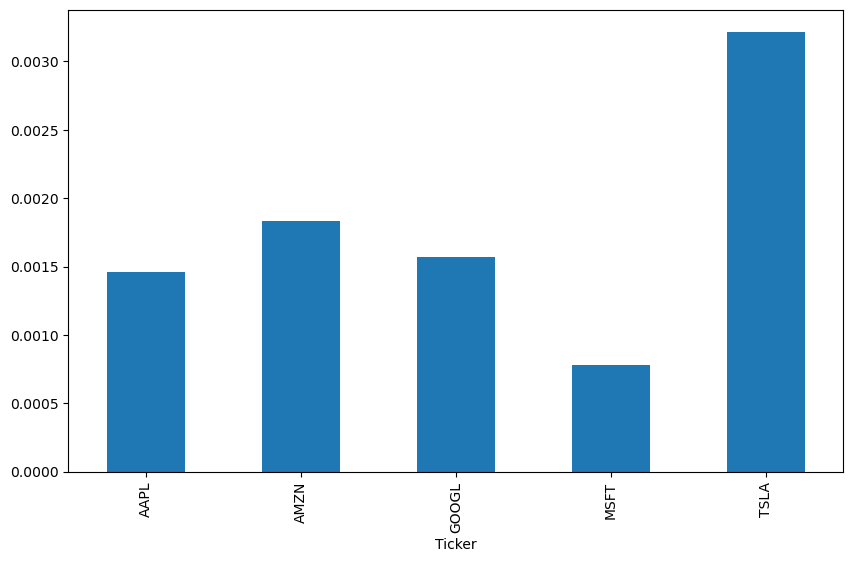

In [32]:
#每天的增长率
close_prices.pct_change().mean().plot(kind="bar",figsize = (10,6))


<Axes: xlabel='Date'>

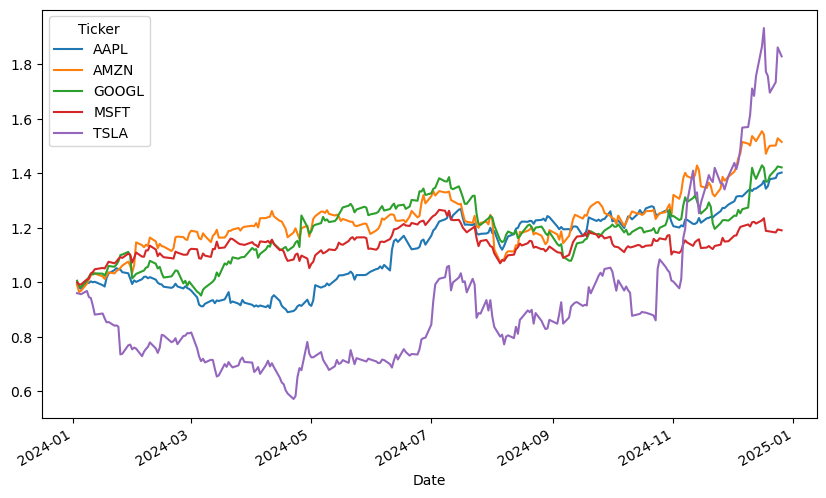

In [33]:
#How much does $1 on the first day equate to on the last day
ccon_change = np.log(close_prices/close_prices.shift(1))
ccon_change.head().round(3)
#restore
ccon_change.cumsum().apply(np.exp).plot(figsize=(10,6))

In [34]:
#close_prices.resample("1w").last().head()
close_prices.resample("1w",label = "right").last().head()

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2024-01-07,179.862854,145.240005,135.084152,363.622437,237.490005
2024-01-14,184.568375,154.619995,141.971252,384.109863,218.889999
2024-01-21,190.167374,155.339996,145.683487,394.195374,212.190002
2024-01-28,191.021118,159.119995,151.465836,399.396332,183.250000
2024-02-04,184.498901,171.809998,141.702530,406.604462,187.910004


In [35]:
＃df = close_prices.dropna()
#10天为窗口滑动
windows = 10

df["AAPL"].rolling(window = windows).mean()

SyntaxError: invalid character '＃' (U+FF03) (1673879172.py, line 1)

In [ ]:
#短均和长均
df = close_prices

df["20d"] = df["AAPL"].rolling(window = 20).mean()
df["60d"] = df["AAPL"].rolling(window = 60).mean()


C:\Users\602599140\AppData\Local\Temp\ipykernel_14072\2286771958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["20d"] = df["AAPL"].rolling(window = 20).mean()
C:\Users\602599140\AppData\Local\Temp\ipykernel_14072\2286771958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["60d"] = df["AAPL"].rolling(window = 60).mean()


In [ ]:
#death cross and gold cross
df["avg_jud"]= np.where(df["20d"]>df["60d"],1,-1)
df.head()

C:\Users\602599140\AppData\Local\Temp\ipykernel_14072\1124018969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["avg_jud"]= np.where(df["20d"]>df["60d"],1,-1)


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA,20d,60d,avg_jud
Date,,,,,,,,
2024-01-02,185.639999,149.929993,138.169998,370.869995,248.419998,NaN,NaN,-1
2024-01-03,184.250000,148.470001,138.919998,370.600006,238.449997,NaN,NaN,-1
2024-01-04,181.910004,144.570007,136.389999,367.940002,237.929993,NaN,NaN,-1
2024-01-05,181.179993,145.240005,135.729996,367.750000,237.490005,NaN,NaN,-1
2024-01-08,185.559998,149.100006,138.839996,374.690002,240.449997,NaN,NaN,-1


<Axes: xlabel='Date'>

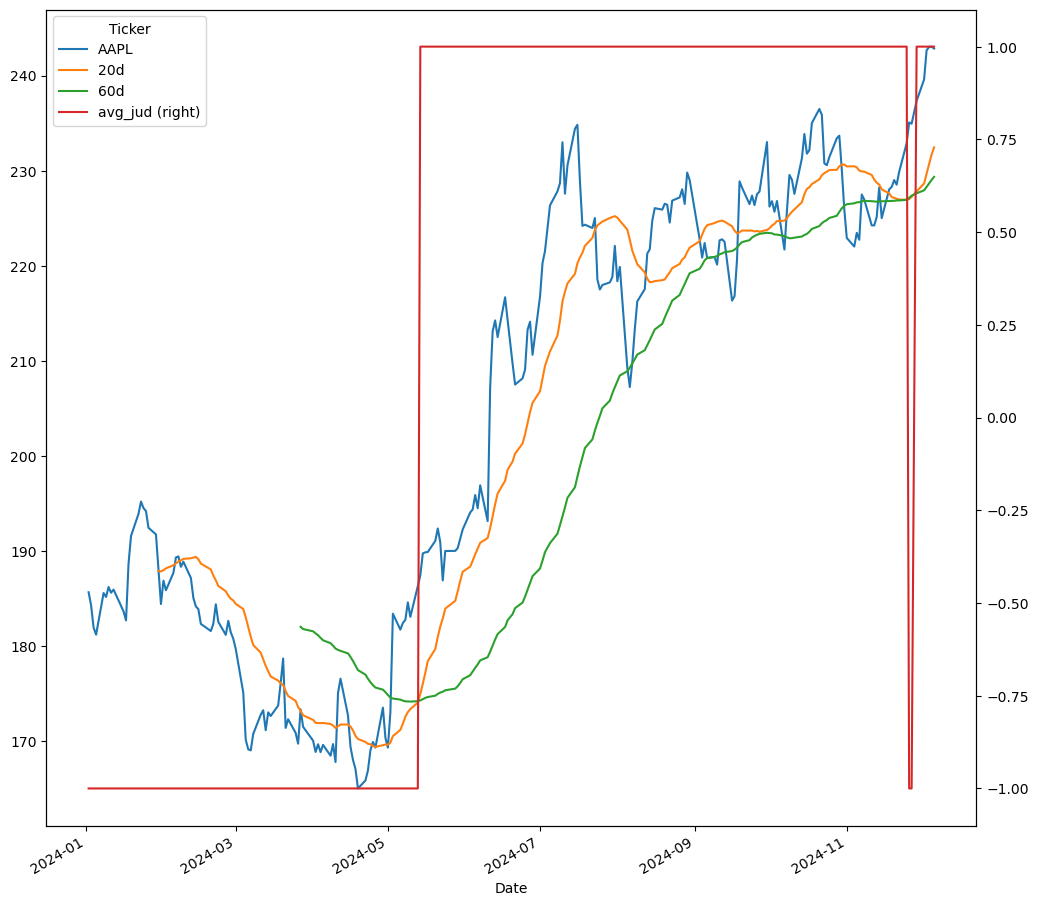

In [ ]:
df[["AAPL","20d","60d"]].tail()
#df[["AAPL","20d","60d"]].plot(figsize= (12,12))
df[["AAPL","20d","60d","avg_jud"]].plot(figsize= (12,12),secondary_y = "avg_jud")

###
1. seeking relationship between two index
2. visualization
3. regression and Correlation coefficient
4. computing the change of correlation with years

In [ ]:
tickers = ["^GSPC", "^VIX"]
# 批量下载股票数据
data = yf.download(tickers, start="2015-01-01", end="2024-12-08", interval="1d")

# 提取收盘价数据
df_c = data['Close']
df_c.columns = ["SPY","VIX"]
df_c.head()

[*********************100%%**********************]  2 of 2 completed


,SPY,VIX
Date,,
2015-01-02,2058.199951,17.790001
2015-01-05,2020.579956,19.920000
2015-01-06,2002.609985,21.120001
2015-01-07,2025.900024,19.309999
2015-01-08,2062.139893,17.010000


<Axes: xlabel='Date'>

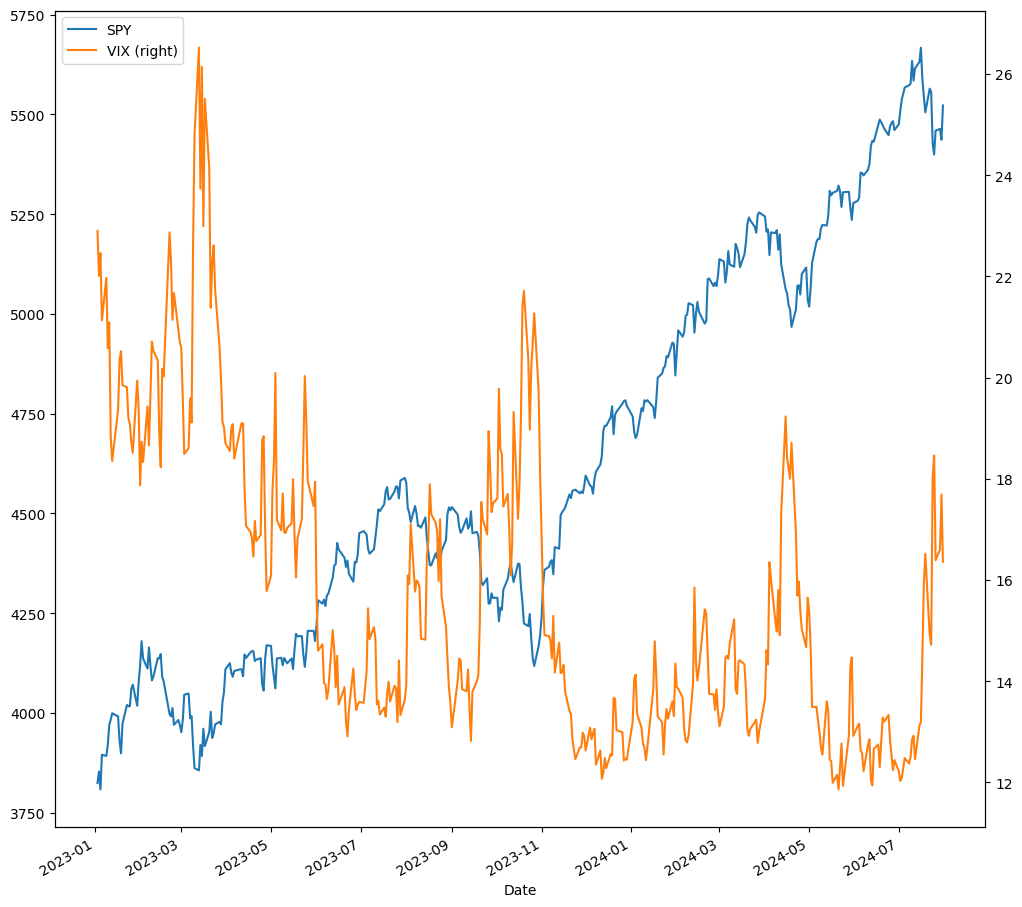

In [ ]:
#visualization of relationship
df_c.loc[:'2024-07-31'].plot(figsize= (12,12),secondary_y = "VIX")

array([[<Axes: xlabel='SPY', ylabel='SPY'>,
        <Axes: xlabel='VIX', ylabel='SPY'>],
       [<Axes: xlabel='SPY', ylabel='VIX'>,
        <Axes: xlabel='VIX', ylabel='VIX'>]], dtype=object)

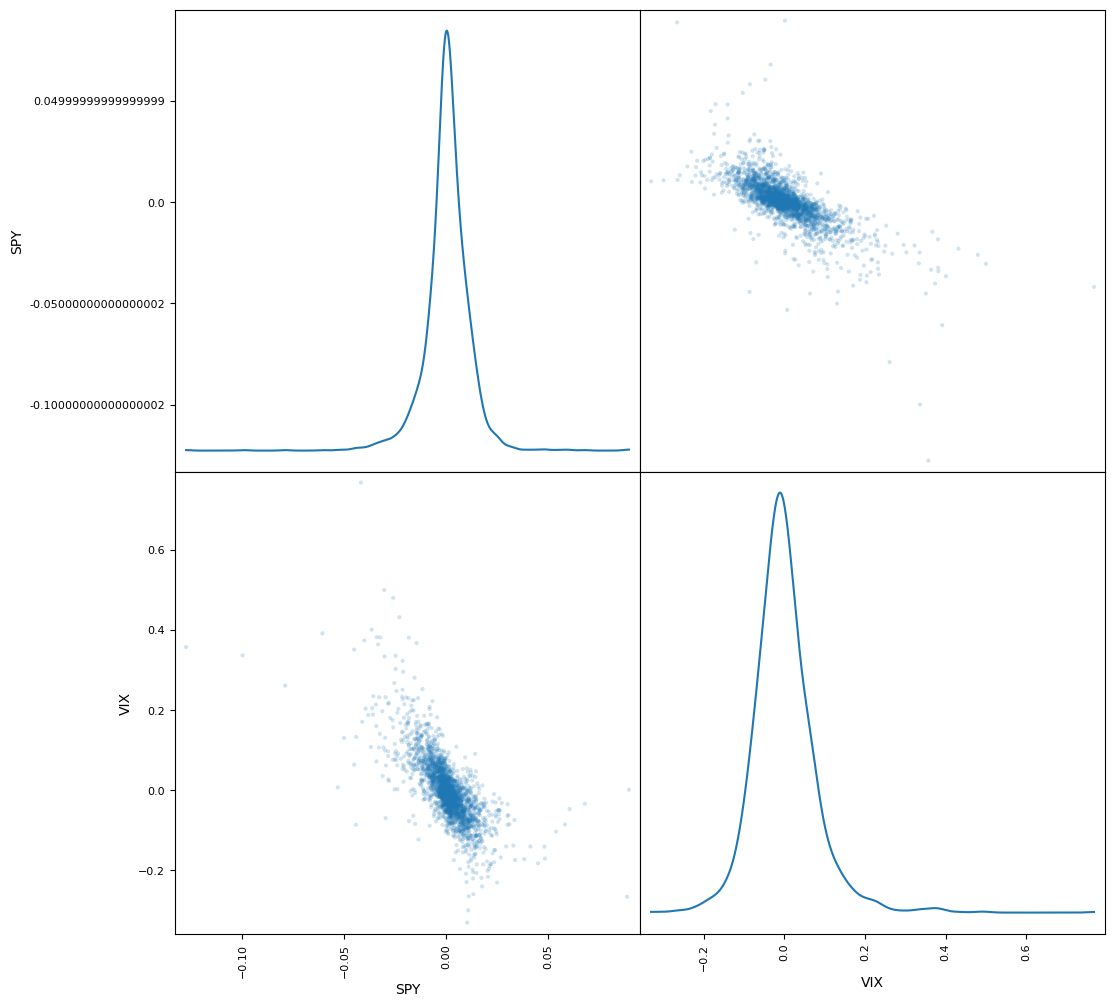

In [ ]:
#to show negative relationship
grow_rate = np.log(df_c/df_c.shift(1))
grow_rate.dropna(inplace = True)
pd.plotting.scatter_matrix(grow_rate,
                           alpha = 0.2,
                           #diagonal = 'hist',
                           #hist_kwds = {'bins':50},
                           diagonal = 'kde',
                           figsize = (12,12)
                          )

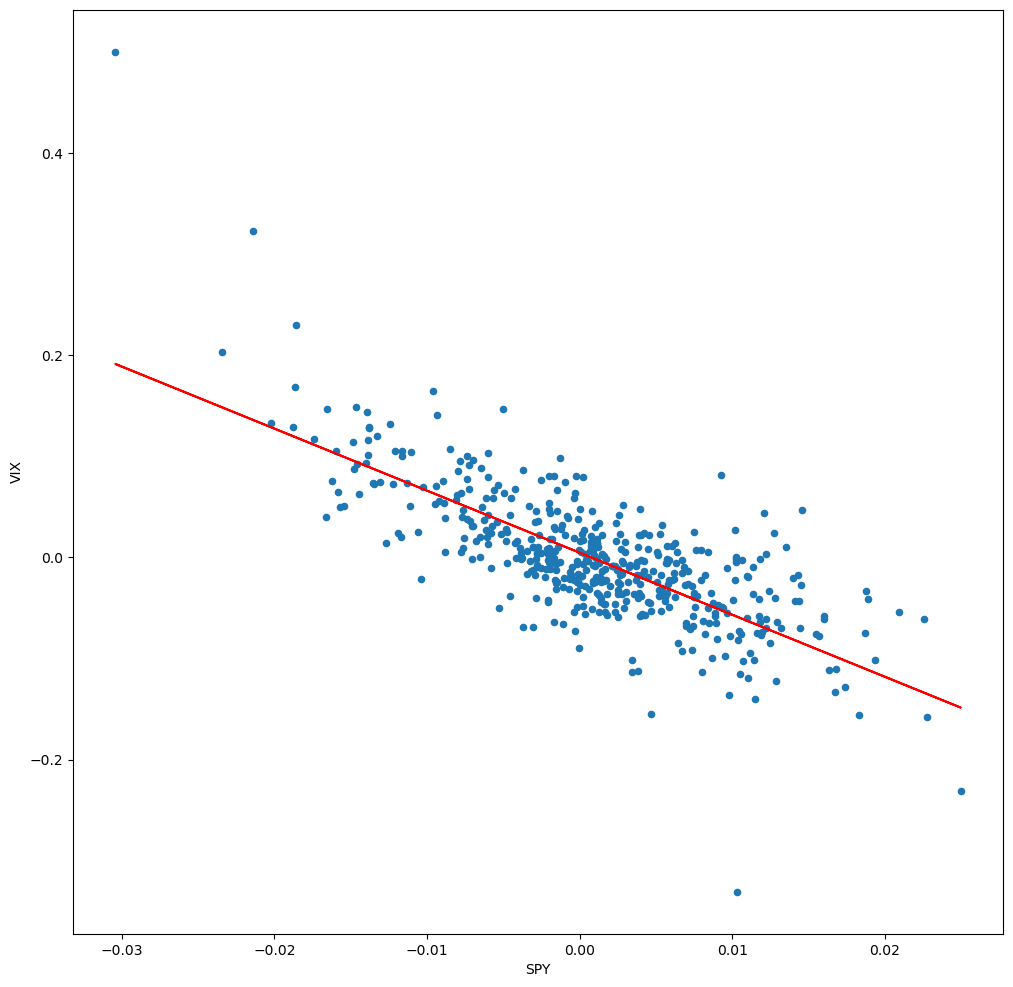

In [ ]:
#built regression model para: x,y, deg:set exponent
#corelationship coefficient
regression = np.polyfit(grow_rate['SPY'],grow_rate['VIX'],deg= 1)
#grow_rate.corr()
plo = grow_rate.plot(kind='scatter',x = 'SPY',y = 'VIX',figsize = (12,12))
plo.plot(grow_rate['SPY'],np.polyval(regression,grow_rate['SPY']),'r')

<Axes: xlabel='Date'>

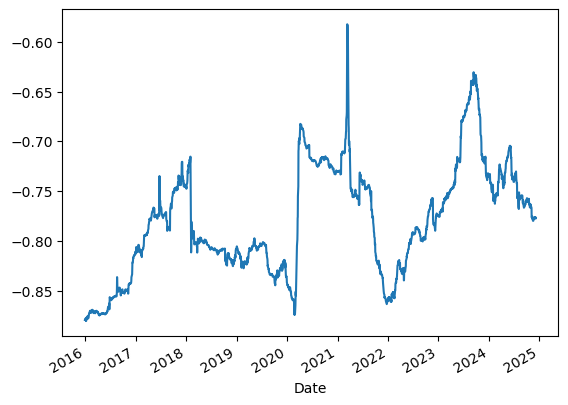

In [ ]:
# computing change
grow_rate['SPY'].rolling(window = 250).corr(grow_rate['VIX']).plot()

*******TWO MA strategy*******
1. preprocessing: remove NA, check outlier
2. determining short and long
3. Execute the strategy and calculate the return

In [ ]:
#preprocessing
df = close_prices[['AAPL']].dropna()

<Axes: xlabel='Date'>

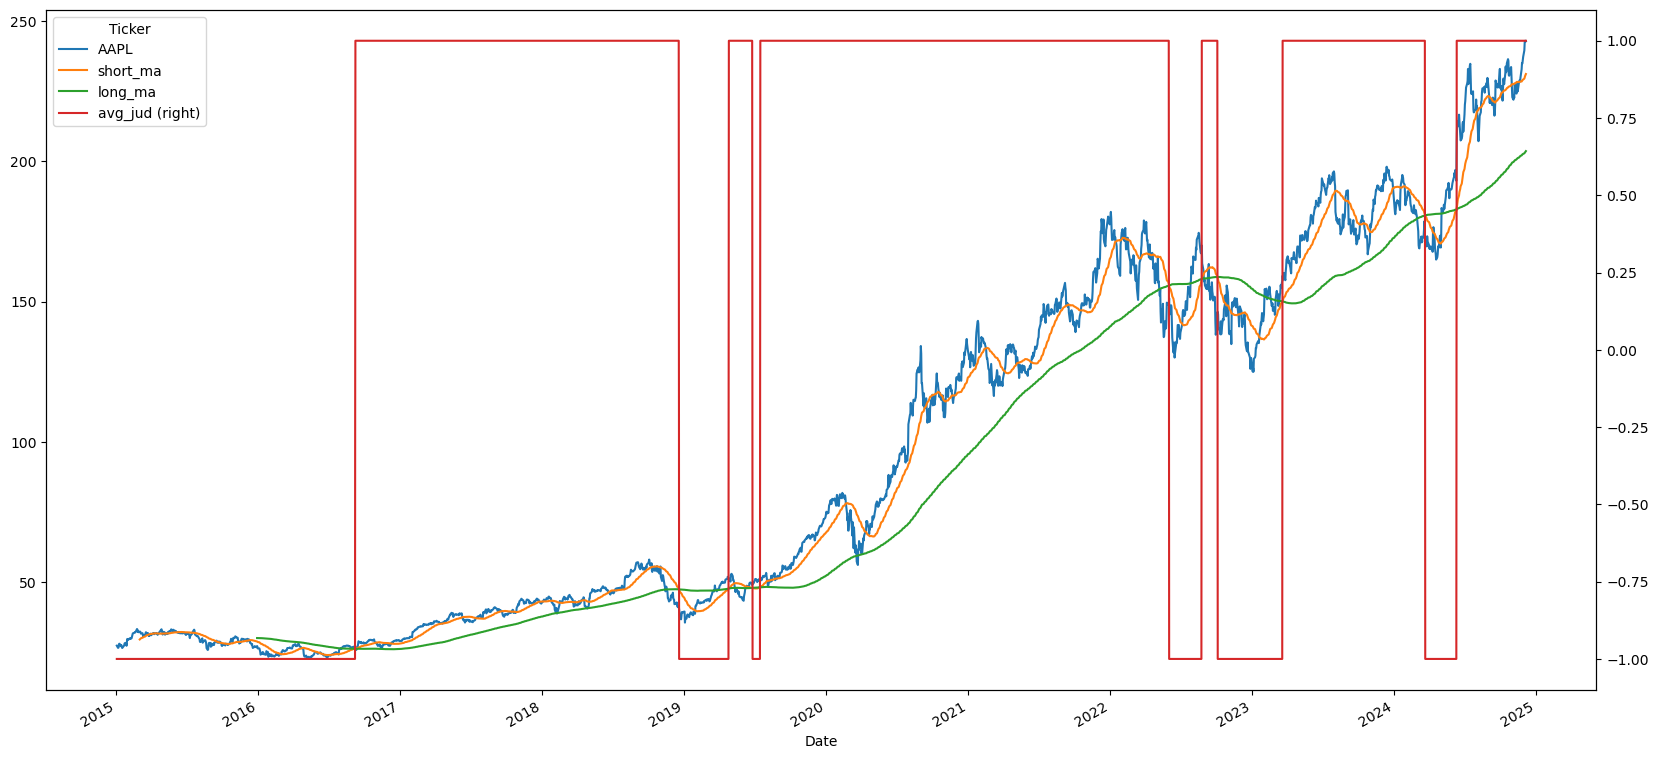

In [ ]:
short_ma =40
long_ma = 250
df["short_ma"]=df['AAPL'].rolling(short_ma).mean()
df["long_ma"]=df['AAPL'].rolling(long_ma).mean()
df["avg_jud"]= np.where(df["short_ma"]>df["long_ma"],1,-1)
df[["AAPL","short_ma","long_ma","avg_jud"]].plot(figsize= (20,10),secondary_y = "avg_jud")

In [ ]:
#non-strategic and strategic return
df["returns"] = np.log(df['AAPL']/df['AAPL'].shift(1))
df["st_returns"] = df['avg_jud'].shift(1)*df["returns"]
df.dropna(inplace=True)
np.exp(df[['returns','st_returns']].sum())

Ticker
returns       3.625780
st_returns    4.024199
dtype: float64

In [ ]:
#Adjust parameters
from itertools import product
df = close_prices[['AAPL']].dropna()
short_ma = [20,40,60,80]
long_ma = [150,200,250,280]
res = pd.DataFrame(columns=["short_ma", "long_ma", "returns", "st_returns", "performance"])

# Traverse all combinations of (short_ma, long_ma) parameters.
for ma1, ma2 in product(short_ma, long_ma):
    if ma1 >= ma2:
        continue
    df_temp = df.copy()

    df_temp["returns"] = np.log(df_temp['AAPL'] / df_temp['AAPL'].shift(1))
    df_temp["short_ma"] = df_temp['AAPL'].rolling(ma1).mean()
    df_temp["long_ma"] = df_temp['AAPL'].rolling(ma2).mean()
    df_temp.dropna(inplace=True)
    df_temp["avg_jud"] = np.where(df_temp["short_ma"] > df_temp["long_ma"], 1, -1)
    df_temp["st_returns"] = df_temp["avg_jud"].shift(1) * df_temp["returns"]
    df_temp.dropna(inplace=True)
    performance = np.exp(df_temp[['returns', 'st_returns']].sum())

    res = pd.concat([res, pd.DataFrame({
        'short_ma': [ma1],
        'long_ma': [ma2],
        'returns': [performance['returns']],
        'st_returns': [performance['st_returns']],
        'performance': [performance['st_returns'] - performance['returns']]
    })], ignore_index=True)
print('over')

over


*******Strategy Evaluation Metrics*******
1.Annualized Return

In [ ]:
df = close_prices[['AAPL']].dropna()
df_new = df/df.iloc[0]
#df_new.plot(figsize=(12,6))
returns = df_new.iloc[-1]-1
#a_return = (df.fillna(method= 'pad')).apply(lambda x:x/x.shift(1)-1)[1:]
a_return = pd.DataFrame(returns.values,columns= ['returns'],index= returns.index)

months = 12
a_return['annual_returns'] = ((1 + a_return['returns']) ** (12 / months) - 1)
v

,returns,annual_returns
Ticker,,
AAPL,0.395281,0.395281


*******Strategy Evaluation Metrics*******
2.Maximum Drawdown

In [ ]:
df_md = df['2023-01-01':'2023-12-30']
df_md["Peak"] = df_md["AAPL"].cummax()
df_md['Drawdown'] = (df_md['AAPL']- df_md["Peak"])/df_md["Peak"]
max_drawdown = df_md['Drawdown'].min()
print("max drawdown:",max_drawdown)
print("occur in:",df_md['Drawdown'].idxmin())

max drawdown: -0.15047084763448376
occur in: 2023-10-26 00:00:00


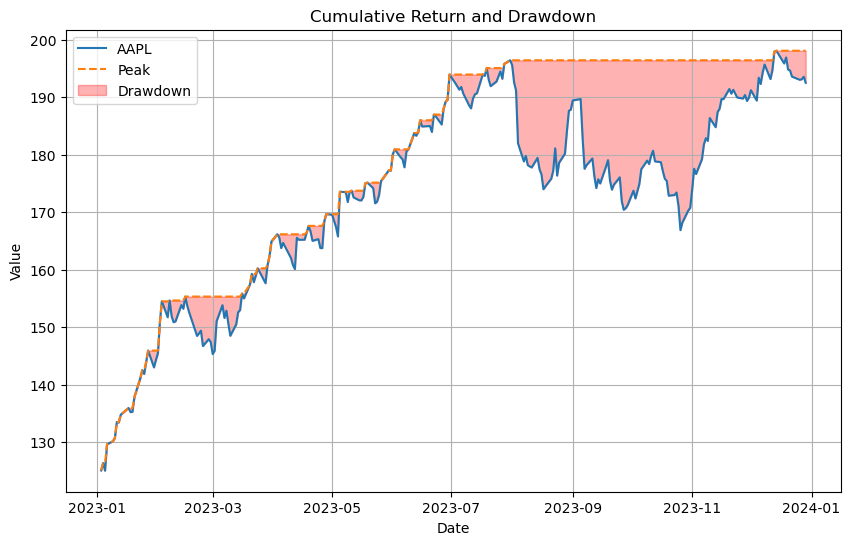

In [ ]:
#drawdown curve
plt.figure(figsize=(10, 6))
plt.plot(df_md.index, df_md["AAPL"], label="AAPL")
plt.plot(df_md.index, df_md["Peak"], label="Peak", linestyle="--")
plt.fill_between(df_md.index, df_md["AAPL"], df_md["Peak"], color="red", alpha=0.3, label="Drawdown")
plt.title("Cumulative Return and Drawdown")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

*******Strategy Evaluation Metrics*******
3.Sharpe Ratio

In [ ]:
df = close_prices[['AAPL']].dropna()

In [ ]:
# Get the US 10-year Treasury yield  (^TNX)
ticker = "^TNX"
ten_year_yield = yf.Ticker(ticker)
historical_data = ten_year_yield.history(start="2024-01-01", end="2024-12-27")

# computing risk free yield (R_f)
historical_data["Yield"] = historical_data["Close"] / 10  
risk_free_rate = historical_data["Yield"].mean() / 100
risk_free_rate

0.00420265461737851

*****Annualized Volatility*****
Assume that daily return fluctuations are independent and identically distributed.
The total volatility of cumulative returns increases with time, but the rate of increase is the square root of time.

In [ ]:
#Annualized Volatility
df["Log Return"] = np.log(df["AAPL"] / df["AAPL"].shift(1))
df = df.dropna()
# Calculate the standard deviation of daily returns
daily_std = df["Log Return"].std()

# 4. Annualized Volatility
a_return["annual_volatility"] = daily_std * np.sqrt(252)

In [ ]:

# Sharpe Ratio
a_return["sharpe_ratio"] = (a_return["annual_returns"] - risk_free_rate) / a_return["annual_volatility"]
a_return

,returns,annual_returns,annual_volatility,sharpe_ratio
Ticker,,,,
AAPL,0.395281,0.395281,0.223487,1.749894


In [ ]:
# 年份列表
years = [2025, 2024, 2023, 2022]

# 存储各年数据的列表
dfs = []

for year in years:
    # 构建带年份过滤的 URL
    url = (
        "https://home.treasury.gov/resource-center/data-chart-center/"
        "interest-rates/TextView"
        f"?type=daily_treasury_yield_curve&field_tdr_date_value={year}"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find("table")
    
    # 提取表头
    headers = [th.get_text(strip=True) for th in table.find_all("th")]
    # 提取行
    rows = []
    for tr in table.find_all("tr")[1:]:
        cells = [td.get_text(strip=True) for td in tr.find_all("td")]
        if cells:
            rows.append(cells)
    
    # 转为 DataFrame
    df_year = pd.DataFrame(rows, columns=headers)
    df_year["Date"] = pd.to_datetime(df_year["Date"])
    df_year.set_index("Date", inplace=True)
    
    dfs.append(df_year)

# 合并所有年份的数据
df_all = pd.concat(dfs).sort_index()

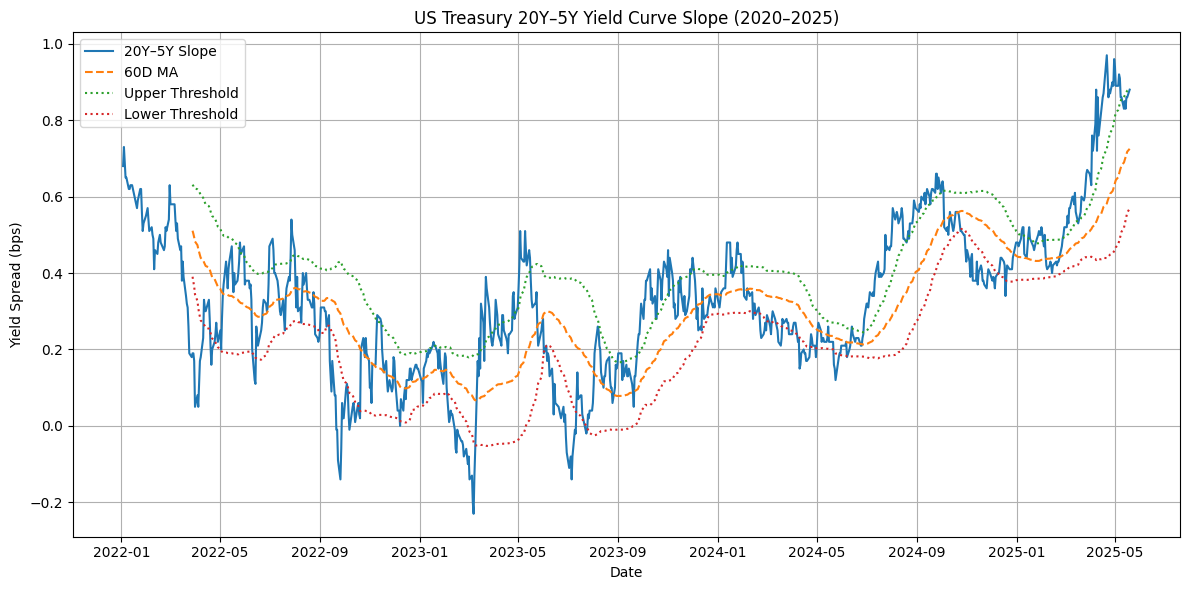

              Y5   Y20  Slope        MA     Upper     Lower  Signal
Date                                                               
2025-05-06  3.90  4.82   0.92  0.659500  0.836158  0.482842       1
2025-05-07  3.87  4.78   0.91  0.667667  0.844392  0.490942       1
2025-05-08  4.00  4.86   0.86  0.674833  0.850473  0.499194       1
2025-05-09  4.00  4.86   0.86  0.682167  0.856163  0.508170       1
2025-05-12  4.09  4.92   0.83  0.689333  0.860341  0.518326       0
2025-05-13  4.12  4.97   0.85  0.696500  0.865021  0.527979       0
2025-05-14  4.17  5.00   0.83  0.703167  0.868855  0.537479       0
2025-05-15  4.07  4.93   0.86  0.710500  0.873152  0.547848       0
2025-05-16  4.06  4.92   0.86  0.717667  0.877193  0.558140       0
2025-05-19  4.07  4.95   0.88  0.725167  0.881485  0.568848       0


In [ ]:
# 提取并转换 5Y 和 20Y 列
df = df_all.rename(columns={'5 Yr': 'Y5', '20 Yr': 'Y20'})
df[['Y5', 'Y20']] = df[['Y5', 'Y20']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['Y5', 'Y20'])

# 计算 20Y-5Y 利差
df['Slope'] = df['Y20'] - df['Y5']

# 计算 60 日滚动均值和标准差，构建阈值
window = 60
df['MA'] = df['Slope'].rolling(window).mean()
df['STD'] = df['Slope'].rolling(window).std()
k = 1.0
df['Upper'] = df['MA'] + k * df['STD']
df['Lower'] = df['MA'] - k * df['STD']

# 生成交易信号
df['Signal'] = 0
df.loc[df['Slope'] > df['Upper'], 'Signal'] = 1
df.loc[df['Slope'] < df['Lower'], 'Signal'] = -1

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Slope'], label='20Y–5Y Slope')
plt.plot(df.index, df['MA'], linestyle='--', label='60D MA')
plt.plot(df.index, df['Upper'], linestyle=':', label='Upper Threshold')
plt.plot(df.index, df['Lower'], linestyle=':', label='Lower Threshold')
plt.title('US Treasury 20Y–5Y Yield Curve Slope (2020–2025)')
plt.xlabel('Date')
plt.ylabel('Yield Spread (bps)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 打印最近 10 条信号
print(df[['Y5', 'Y20', 'Slope', 'MA', 'Upper', 'Lower', 'Signal']].tail(10))

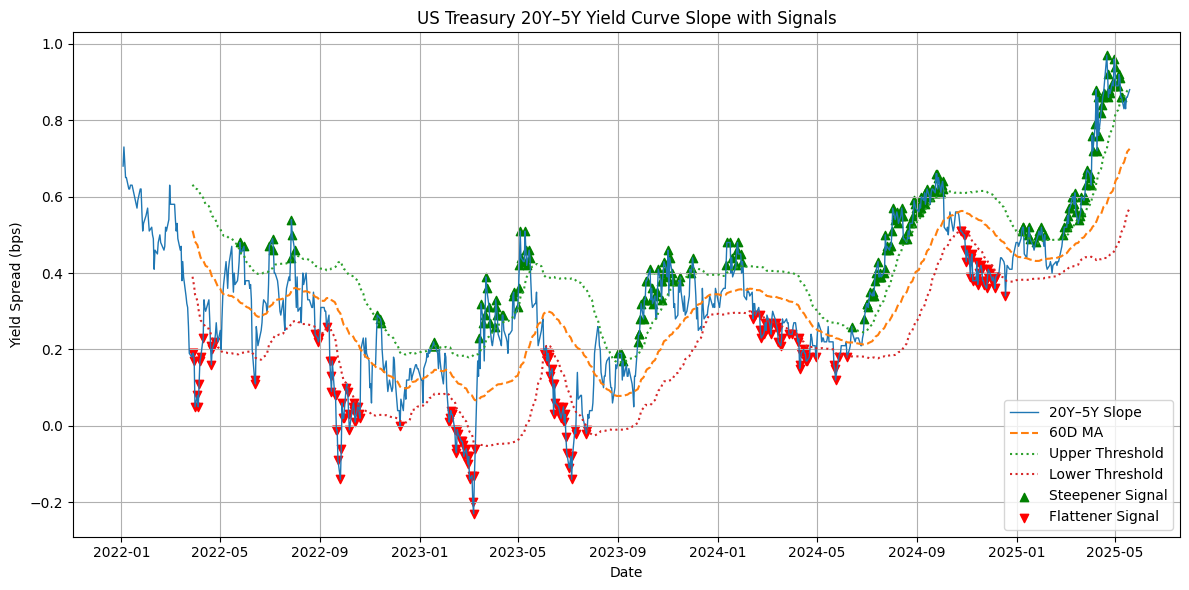

In [ ]:
# 提取并转换 5Y 和 20Y 列
df = df_all.rename(columns={'5 Yr': 'Y5', '20 Yr': 'Y20'})
df[['Y5', 'Y20']] = df[['Y5', 'Y20']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['Y5', 'Y20'])

# 计算 20Y-5Y 利差
df['Slope'] = df['Y20'] - df['Y5']
# 4. 计算滚动统计和信号
window = 60
df['MA'] = df['Slope'].rolling(window).mean()
df['STD'] = df['Slope'].rolling(window).std()
k = 1.0
df['Upper'] = df['MA'] + k * df['STD']
df['Lower'] = df['MA'] - k * df['STD']
df['Signal'] = 0
df.loc[df['Slope'] > df['Upper'], 'Signal'] = 1
df.loc[df['Slope'] < df['Lower'], 'Signal'] = -1

# 5. 可视化并标记信号
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Slope'], label='20Y–5Y Slope', linewidth=1)
plt.plot(df.index, df['MA'], linestyle='--', label='60D MA')
plt.plot(df.index, df['Upper'], linestyle=':', label='Upper Threshold')
plt.plot(df.index, df['Lower'], linestyle=':', label='Lower Threshold')

# 标记Signal为1的点（Steepener）和Signal为-1的点（Flattener）
steep_dates = df[df['Signal'] == 1].index
flat_dates = df[df['Signal'] == -1].index
plt.scatter(steep_dates, df.loc[steep_dates, 'Slope'], marker='^', color='green', label='Steepener Signal')
plt.scatter(flat_dates, df.loc[flat_dates, 'Slope'], marker='v', color='red', label='Flattener Signal')

plt.title('US Treasury 20Y–5Y Yield Curve Slope with Signals')
plt.xlabel('Date')
plt.ylabel('Yield Spread (bps)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 1. 定义ETF代码和各自的久期（年）
tickers = {
    "2856.T": 5.0,   # 3–7年ETF，久期约5年
    "2621.T": 8.0    # 7–10年ETF，久期约8年
}

# 2. 获取历史价格数据
start_date = "2025-01-01"
end_date = "2025-05-20"
data = yf.download(list(tickers.keys()), start=start_date, end=end_date)["Adj Close"]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 2 completed

2 Failed downloads:
['2856.T', '2621.T']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 2 completed

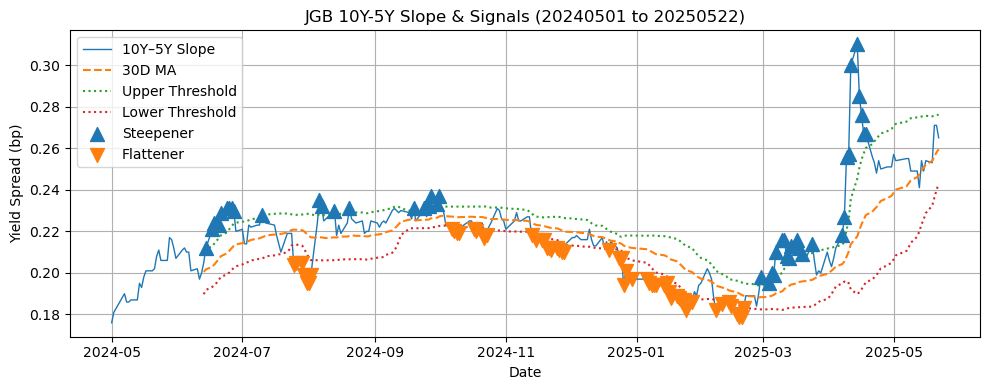

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

def fetch_jgb_yields(start, end, window=30):
# 主数据源
    url_main = "https://www.mof.go.jp/jgbs/reference/interest_rate/data/jgbcm_all.csv"
    # 补充源（最近利率）
    url_extra = "https://www.mof.go.jp/jgbs/reference/interest_rate/jgbcm.csv"
    

    def load_csv(url):
            resp = requests.get(url)
            resp.encoding = 'shift_jis'
            df = pd.read_csv(StringIO(resp.text), skiprows=1)
            
            # 转换日本年号到公元日期
            def to_greg(s):
                if not isinstance(s, str):
                    return pd.NaT
                m = re.match(r'([SRH])(\d+)\.(\d+)\.(\d+)', s)
                if not m:
                    return pd.NaT
                era, y, mo, d = m.groups()
                base = {'S':1926, 'H':1989, 'R':2019}[era]
                return datetime(base + int(y) - 1, int(mo), int(d))
            
            # 应用日期转换，并设置为索引
            df['Date'] = df.iloc[:, 0].map(to_greg)
            df.set_index('Date', inplace=True)
            df.index = df.index.normalize()
            df = df[~df.index.isna()]
            return df

    # 加载、合并、去重
    df_main  = load_csv(url_main)
    df_extra = load_csv(url_extra)
    df_raw = pd.concat([df_main, df_extra])
    df_raw = df_raw[~df_raw.index.duplicated(keep='last')]

    # ✅ 排序索引，保证单调递增
    df_raw = df_raw.sort_index()
    
    # 按日期切片
    df_period = df_raw.loc[start:end]
    df_clean  = df_period.rename(columns={'8年':'Y8', '10年':'Y10'})[['Y8','Y10']].astype(float).dropna()
    
    # 计算指标
    df_clean['Slope'] = df_clean['Y10'] - df_clean['Y8']
    df_clean['MA']    = df_clean['Slope'].rolling(window).mean()
    df_clean['STD']   = df_clean['Slope'].rolling(window).std()
    df_clean['Upper'] = df_clean['MA'] + df_clean['STD']
    df_clean['Lower'] = df_clean['MA'] - df_clean['STD']
    df_clean['Signal']= 0
    df_clean.loc[df_clean['Slope'] > df_clean['Upper'], 'Signal'] = 1
    df_clean.loc[df_clean['Slope'] < df_clean['Lower'], 'Signal'] = -1
    
    return df_clean

# 使用示例
start_date, end_date = '20240501', '20250522'
df = fetch_jgb_yields(start_date, end_date, window=30)

# --- 5. 可视化并标记信号 ---
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Slope'], label='10Y–5Y Slope', linewidth=1)
plt.plot(df.index, df['MA'], linestyle='--', label='30D MA')
plt.plot(df.index, df['Upper'], linestyle=':', label='Upper Threshold')
plt.plot(df.index, df['Lower'], linestyle=':', label='Lower Threshold')

# 标记策略信号：1=Steepener, -1=Flattener
steep_dates = df[df['Signal'] == 1].index
flat_dates  = df[df['Signal'] == -1].index
plt.scatter(steep_dates, df.loc[steep_dates, 'Slope'], marker='^', s=100, label='Steepener', zorder=5)
plt.scatter(flat_dates, df.loc[flat_dates, 'Slope'],   marker='v', s=100, label='Flattener',  zorder=5)

plt.title(f'JGB 10Y-5Y Slope & Signals ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Yield Spread (bp)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
today_str

'20250526'

In [ ]:
import plotly.graph_objects as go

# —— 假设你已经得到了 df（含 ['Slope','MA','Upper','Lower','Signal']）
# —— 以及 start_date, end_date
today_str = date.today().strftime('%Y%m%d')
start_date, end_date = '20240901', today_str
df = fetch_jgb_yields(start_date, end_date, window=40)
# 标记信号日期
steep_dates = df[df['Signal'] == 1].index
flat_dates  = df[df['Signal'] == -1].index

# 创建 Figure
fig = go.Figure()

# 1) 绘制斜率和均线、上下轨
fig.add_trace(go.Scatter(
    x=df.index, y=df['Slope'], mode='lines', name='10Y–5Y Slope'
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['MA'], mode='lines', name='30D MA',
    line=dict(dash='dash')
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['Upper'], mode='lines', name='Upper Threshold',
    line=dict(dash='dot')
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['Lower'], mode='lines', name='Lower Threshold',
    line=dict(dash='dot')
))

# 2) 添加 Steepener 信号点
fig.add_trace(go.Scatter(
    x=steep_dates,
    y=df.loc[steep_dates, 'Slope'],
    mode='markers',
    name='Steepener',
    marker_symbol='triangle-up',
    marker_size=10,
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Slope: %{y:.3f}<extra></extra>'
))

# 3) 添加 Flattener 信号点
fig.add_trace(go.Scatter(
    x=flat_dates,
    y=df.loc[flat_dates, 'Slope'],
    mode='markers',
    name='Flattener',
    marker_symbol='triangle-down',
    marker_size=10,
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Slope: %{y:.3f}<extra></extra>'
))

# 布局调整
fig.update_layout(
    title=f'JGB 10Y-5Y Slope & Signals ({start_date} to {end_date})',
    xaxis_title='Date',
    yaxis_title='Yield Spread (bp)',
    hovermode='closest'
)

# 显示交互式图表
fig.show()

In [ ]:
import plotly.graph_objects as go

# —— 假设你已经得到了 df（含 ['Slope','MA','Upper','Lower','Signal']）
# —— 以及 start_date, end_date
today_str = date.today().strftime('%Y%m%d')
start_date, end_date = '20240901', today_str
df = fetch_ust_yield_spread(start_date, end_date, window=40)
# 标记信号日期
steep_dates = df[df['Signal'] == 1].index
flat_dates  = df[df['Signal'] == -1].index

# 创建 Figure
fig = go.Figure()

# 1) 绘制斜率和均线、上下轨
fig.add_trace(go.Scatter(
    x=df.index, y=df['Slope'], mode='lines', name='10Y–5Y Slope'
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['MA'], mode='lines', name='30D MA',
    line=dict(dash='dash')
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['Upper'], mode='lines', name='Upper Threshold',
    line=dict(dash='dot')
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['Lower'], mode='lines', name='Lower Threshold',
    line=dict(dash='dot')
))

# 2) 添加 Steepener 信号点
fig.add_trace(go.Scatter(
    x=steep_dates,
    y=df.loc[steep_dates, 'Slope'],
    mode='markers',
    name='Steepener',
    marker_symbol='triangle-up',
    marker_size=10,
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Slope: %{y:.3f}<extra></extra>'
))

# 3) 添加 Flattener 信号点
fig.add_trace(go.Scatter(
    x=flat_dates,
    y=df.loc[flat_dates, 'Slope'],
    mode='markers',
    name='Flattener',
    marker_symbol='triangle-down',
    marker_size=10,
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Slope: %{y:.3f}<extra></extra>'
))

# 布局调整
fig.update_layout(
    title=f'UST 20Y-5Y Slope & Signals ({start_date} to {end_date})',
    xaxis_title='Date',
    yaxis_title='Yield Spread (bp)',
    hovermode='closest'
)

# 显示交互式图表
fig.show()



In [ ]:
import math

def compute_duration_neutral_allocation(principal, duration_short, duration_long, price_short, price_long):
    """
    计算久期中性配置下的 ETF 名义金额和份额
    参数:
      principal (float): 本金（如 100000 日元）
      duration_short (float): 短端久期 (e.g., 4.22)
      duration_long (float): 长端久期 (e.g., 15.50)
      price_short (float): 短端 ETF 收盘价 (e.g., 680)
      price_long (float): 长端 ETF 收盘价 (e.g., 1061)
    返回:
      dict: 包含名义金额和份额 {'notional_short', 'notional_long', 'shares_short', 'shares_long'}
    """
    # 1. 计算名义金额
    notional_short = principal * duration_long / (duration_short + duration_long)
    notional_long = principal - notional_short
    
    # 2. 计算份额（向下取整到整数张）
    shares_short = math.floor(notional_short / price_short)
    shares_long = math.floor(notional_long / price_long)
    
    return {
        'notional_short': notional_short,
        'notional_long': notional_long,
        'shares_short': shares_short,
        'shares_long': shares_long
    }

# 美债
principal = 100000    # 本金（日元）
duration_short = 4.22 # 短端久期
duration_long = 15.50 # 长端久期
price_short = 680     # 2856.T 收盘价
price_long = 1061     # 2621.T 收盘价

result = compute_duration_neutral_allocation(
    principal, duration_short, duration_long, price_short, price_long
)

print("名义金额（短端）：", result['notional_short'])
print("名义金额（长端）：", result['notional_long'])
print("买入份额（短端）2856：", result['shares_short'], "张")
print("卖出份额（长端）2621：", result['shares_long'], "张")


名义金额（短端）： 78600.40567951319
名义金额（长端）： 21399.59432048681
买入份额（短端）2856： 115 张
卖出份额（长端）2621： 20 张


In [ ]:
import math
#日债
principal = 100000    # 本金（日元）
duration_short = 8.2 # 短端久期
duration_long = 10.85 # 长端久期
price_short = 480     # 236a.T 收盘价
price_long = 2207     # 2561.T 收盘价

result = compute_duration_neutral_allocation(
    principal, duration_short, duration_long, price_short, price_long
)

print("名义金额（短端）：", result['notional_short'])
print("名义金额（长端）：", result['notional_long'])
print("买入份额（短端）236a：", result['shares_short'], "张")
print("卖出份额（长端）2561：", result['shares_long'], "张")

名义金额（短端）： 56955.38057742783
名义金额（长端）： 43044.61942257217
买入份额（短端）236a： 118 张
卖出份额（长端）2561： 19 张


In [ ]:
def fetch_ust_yield_spread(start, end, window=30):
    """
    获取美国国债20年-5年期利差，并计算滚动均值、标准差、信号位。
    """

    def load_yearly_yields(year):
        url = (
            "https://home.treasury.gov/resource-center/data-chart-center/"
            "interest-rates/TextView"
            f"?type=daily_treasury_yield_curve&field_tdr_date_value={year}"
        )
        resp = requests.get(url)
        df = pd.read_html(resp.text)[0]
        df = df.rename(columns={"Date": "Date", "5 Yr": "Y5", "20 Yr": "Y20"})
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df = df[['Y5', 'Y20']].astype(float)
        return df

    # 收集目标年份范围内的数据
    year_range = range(pd.to_datetime(start).year, pd.to_datetime(end).year + 1)
    all_data = [load_yearly_yields(year) for year in year_range]
    df_raw = pd.concat(all_data)
    
    # 去重并排序
    df_raw = df_raw[~df_raw.index.duplicated(keep='last')]
    df_raw = df_raw.sort_index()

    # 按日期切片
    df_period = df_raw.loc[start:end].copy()
    df_clean  = df_period.dropna()

    # 计算利差指标
    df_clean['Slope'] = df_clean['Y20'] - df_clean['Y5']
    df_clean['MA']    = df_clean['Slope'].rolling(window).mean()
    df_clean['STD']   = df_clean['Slope'].rolling(window).std()
    df_clean['Upper'] = df_clean['MA'] + df_clean['STD']
    df_clean['Lower'] = df_clean['MA'] - df_clean['STD']
    df_clean['Signal']= 0
    df_clean.loc[df_clean['Slope'] > df_clean['Upper'], 'Signal'] = 1
    df_clean.loc[df_clean['Slope'] < df_clean['Lower'], 'Signal'] = -1

    return df_clean

In [ ]:
#导入函数部分
# --- Module 1: Data Loading ---
def fetch_jgb_yields(start, end, window=30):
# 主数据源
    url_main = "https://www.mof.go.jp/jgbs/reference/interest_rate/data/jgbcm_all.csv"
    # 补充源（最近利率）
    url_extra = "https://www.mof.go.jp/jgbs/reference/interest_rate/jgbcm.csv"
    

    def load_csv(url):
            resp = requests.get(url)
            resp.encoding = 'shift_jis'
            df = pd.read_csv(StringIO(resp.text), skiprows=1)
            
            # 转换日本年号到公元日期
            def to_greg(s):
                if not isinstance(s, str):
                    return pd.NaT
                m = re.match(r'([SRH])(\d+)\.(\d+)\.(\d+)', s)
                if not m:
                    return pd.NaT
                era, y, mo, d = m.groups()
                base = {'S':1926, 'H':1989, 'R':2019}[era]
                return datetime(base + int(y) - 1, int(mo), int(d))
            
            # 应用日期转换，并设置为索引
            df['Date'] = df.iloc[:, 0].map(to_greg)
            df.set_index('Date', inplace=True)
            df.index = df.index.normalize()
            df = df[~df.index.isna()]
            return df

    # 加载、合并、去重
    df_main  = load_csv(url_main)
    df_extra = load_csv(url_extra)
    df_raw = pd.concat([df_main, df_extra])
    df_raw = df_raw[~df_raw.index.duplicated(keep='last')]

    # ✅ 排序索引，保证单调递增
    df_raw = df_raw.sort_index()
    
    # 按日期切片
    df_period = df_raw.loc[start:end]
    df_clean  = df_period.rename(columns={'8年':'Y8', '10年':'Y10'})[['Y8','Y10']].astype(float).dropna()
    
    # 计算指标
    df_clean['Slope'] = df_clean['Y10'] - df_clean['Y8']
    df_clean['MA']    = df_clean['Slope'].rolling(window).mean()
    df_clean['STD']   = df_clean['Slope'].rolling(window).std()
    df_clean['Upper'] = df_clean['MA'] + df_clean['STD']
    df_clean['Lower'] = df_clean['MA'] - df_clean['STD']
    df_clean['Signal']= 0
    df_clean.loc[df_clean['Slope'] > df_clean['Upper'], 'Signal'] = 1
    df_clean.loc[df_clean['Slope'] < df_clean['Lower'], 'Signal'] = -1
    
    return df_clean

def fetch_etf_prices(symbols, start, end):
    """
    从 Stooq 拉取 ETF 收盘价，返回 DataFrame
    """
    def fetch(sym):
        url = f"https://stooq.com/q/d/l/?s={sym}&d1={start}&d2={end}&i=d"
        tmp = pd.read_csv(StringIO(requests.get(url).text),
                          parse_dates=['Date'], index_col='Date')
        return tmp['Close'].sort_index()
    prices = pd.DataFrame({name: fetch(sym) for name, sym in symbols.items()})
    prices.index = prices.index.normalize()
    return prices.loc[start:end].dropna()

# --- Module 2: Strategy & Backtest ---
def run_backtest(signals: pd.DataFrame,
                 prices: pd.DataFrame,
                 durations: dict,
                 position_fn,
                 intraday: bool = False,
                 stop_loss: float = None) -> pd.DataFrame:
    """
    通用回测框架，支持日内/跨日与止损逻辑：
      signals: 包含 ['Slope','MA','Signal']
      prices:  包含 ['Short','Long']
      durations: {'Short':dur_short,'Long':dur_long}
      position_fn: 策略函数(signals,prices)->Series(Position_today)
      intraday: True 时当天 Signal 当天生效；False 则 shift(1)
      stop_loss: 日内最大亏损 (e.g. 0.001 = 0.1%)
    返回含 ['Position','RawReturn','StrategyRet','Cumulative'] 的 DataFrame
    """
    # 1) 计算每日原始组合收益
    rets  = prices.pct_change().dropna()
    hedge = durations['Short'] / durations['Long']
    raw_combo = rets['Short'] - hedge * rets['Long']

    # 2) 生成当天仓位
    df = signals.copy()
    df['Position_today'] = position_fn(signals, prices)
    #日内
    if intraday:
        pos = df['Position_today'].reindex(raw_combo.index).fillna(0).astype(int)
    #跨日
    else:
        pos = df['Position_today'].shift(1).reindex(raw_combo.index).fillna(0).astype(int)

    # 3) 计算策略当天收益，并只对亏损部分止损
    bt = pd.DataFrame({
        'Position':   pos,
        'RawReturn':  raw_combo
    })
    bt['StrategyRet'] = bt['Position'] * bt['RawReturn']
    if stop_loss is not None:
        # 亏损时下限截断到 -stop_loss
        bt['StrategyRet'] = bt['StrategyRet'].clip(lower=-stop_loss)

    # 4) 累计净值
    bt['Cumulative'] = (1 + bt['StrategyRet']).cumprod()
    return bt
# --- Module 3: Visualization ---
def plot_results(bt, output_csv=None):
    """
    在净值曲线上标记 Steepener/Flattener 进入与退出
    """
    df = bt.copy()
    df['PrevPos'] = df['Position'].shift(1).fillna(0)

    # Identify entry and exit points
    entries_steep = df[(df['PrevPos']==0) & (df['Position']==1)]
    entries_flat  = df[(df['PrevPos']==0) & (df['Position']==-1)]
    exits         = df[(df['PrevPos']!=0) & (df['Position']==0)]

    # Calculate total PnL and cumulative return
    total_pnl = df['StrategyRet'].sum()
    cumulative_return_pct = (df['Cumulative'].iloc[-1] - 1) * 100

    # Plot equity curve and markers
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['Cumulative'], label='Equity Curve', color='blue')
    plt.scatter(entries_steep.index, entries_steep['Cumulative'],
                marker='^', color='green', s=80, label='Entry Steepener')
    plt.scatter(entries_flat.index, entries_flat['Cumulative'],
                marker='^', color='red', s=80, label='Entry Flattener')
    plt.scatter(exits.index, exits['Cumulative'],
                marker='v', color='gray', s=80, label='Exit')

    # Annotation box at top-right
    plt.text(0.75, 0.95,
             f"Total PnL: {total_pnl:.4f}\n"
             f"Cumulative Return: {cumulative_return_pct:.2f}%",
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.title('Strategy Equity with Entry/Exit Points')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Equity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Prepare daily PnL table
    pnl_table = df[['Position', 'StrategyRet']].copy()
    pnl_table['StrategyRet'] = pnl_table['StrategyRet'].round(6)

    # Output or save
    if output_csv:
        pnl_table.to_csv(output_csv, float_format='%.6f')
        print(f"Daily PnL saved to {output_csv}")
    else:
        print("Daily PnL:")
        #print(pnl_table)
        print("cumulative return is:",cumulative_return_pct)

# --- Main Execution ---
if __name__ == "__main__":
    start_date, end_date = '20240501', '20250520'
    # 1. JGB 斜率信号
    #signals = fetch_jgb_yields(start_date, end_date, window=30)
    # 2. ETF 价格
    #symbols = {'Short':'236a.jp', 'Long':'2561.jp'}
    #prices = fetch_etf_prices(symbols, start_date, end_date)
    # 3. 回测
    #durations = {'Short': 8.2, 'Long': 10.85}
    #bt = run_backtest(signals, prices, durations)
    # 4. 可视化
    #plot_results(bt, output_csv=None)



In [ ]:
signals.head(5)

,Y8,Y10,Slope,MA,STD,Upper,Lower,Signal
Date,,,,,,,,
2024-09-02,0.712,0.936,0.224,NaN,NaN,NaN,NaN,0
2024-09-03,0.730,0.952,0.222,NaN,NaN,NaN,NaN,0
2024-09-04,0.693,0.917,0.224,NaN,NaN,NaN,NaN,0
2024-09-05,0.679,0.904,0.225,NaN,NaN,NaN,NaN,0
2024-09-06,0.656,0.880,0.224,NaN,NaN,NaN,NaN,0


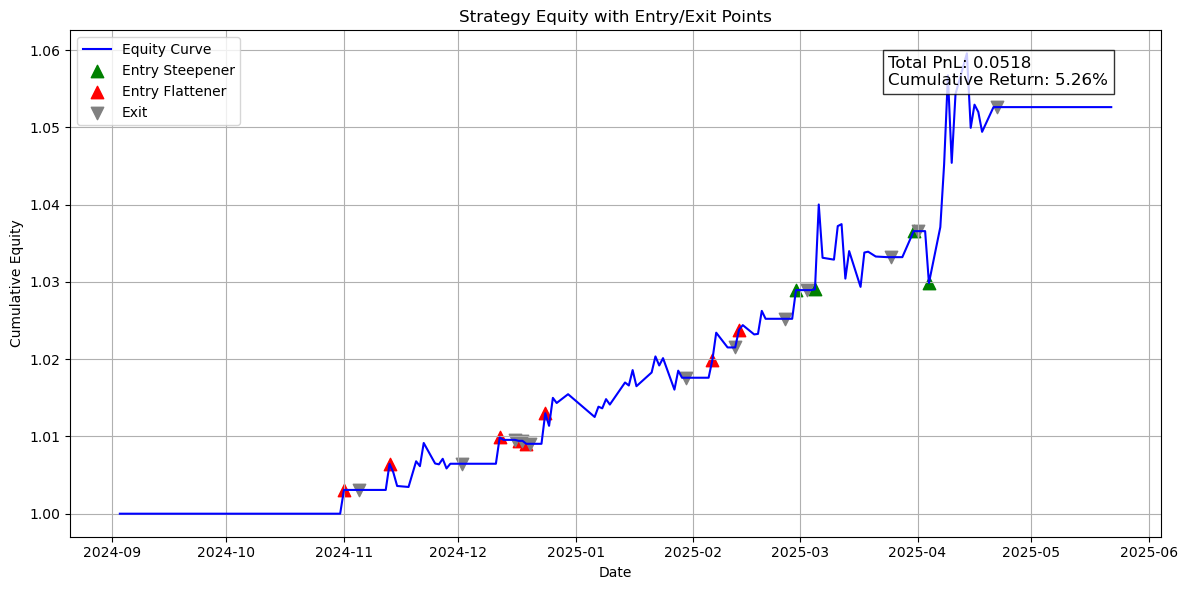

Daily PnL:
cumulative return is: 5.2617986598087585


In [ ]:
#日内策略 只在跌破止损平仓
def strat_intraday_signal(signals, prices):
    return signals['Signal'].reindex(prices.index).fillna(0).astype(int)

start_date, end_date = '20240901', '20250522'
signals = fetch_jgb_yields(start_date, end_date, window=40)
# 2. ETF 价格
symbols = {'Short':'236a.jp', 'Long':'2561.jp'}
prices = fetch_etf_prices(symbols, start_date, end_date)
    # 3. 回测
durations = {'Short': 8.2, 'Long': 10.73}
bt = run_backtest(
    signals, prices, durations,
    position_fn=strat_intraday_signal,
    intraday=True,
    stop_loss=0.01   # 未加百分比 日内止损
)
plot_results(bt)

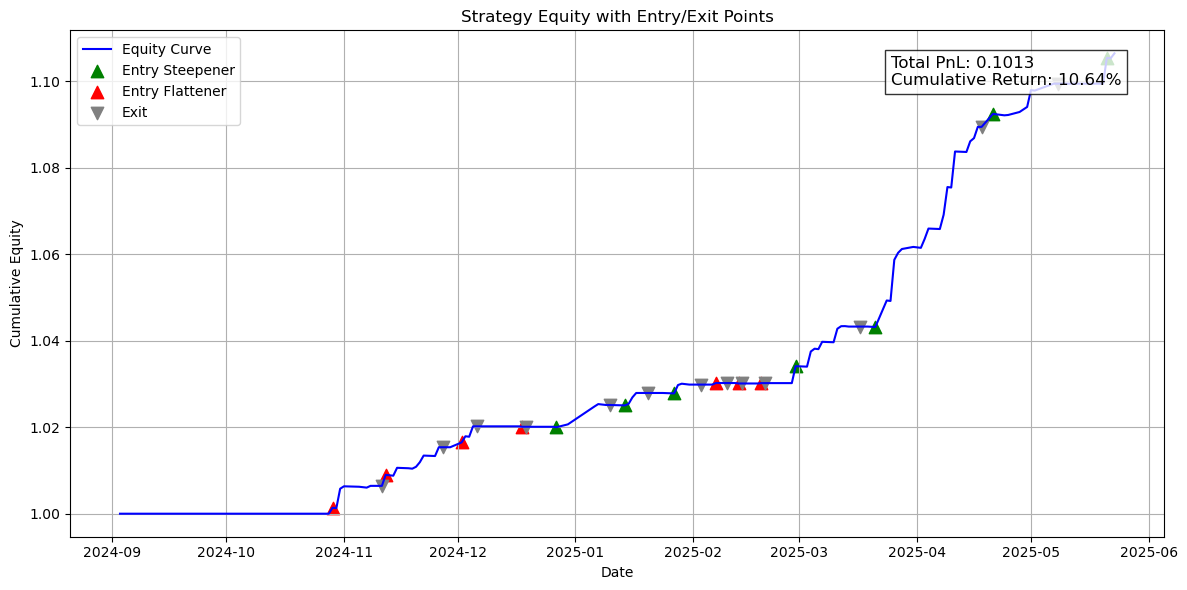

Daily PnL:
cumulative return is: 10.639073588196869


In [ ]:
#日内策略 只在跌破止损平仓
def strat_intraday_signal(signals, prices):
    return signals['Signal'].reindex(prices.index).fillna(0).astype(int)

start_date, end_date = '20240901', '20250523'
signals = fetch_ust_yield_spread(start_date, end_date, window=40)
# 2. ETF 价格
symbols = {'Short':'2856.jp', 'Long':'2621.jp'}
prices = fetch_etf_prices(symbols, start_date, end_date)
    # 3. 回测
durations = {'Short': 4.22, 'Long': 15.50}
bt = run_backtest(
    signals, prices, durations,
    position_fn=strat_intraday_signal,
    intraday=True,
    stop_loss=0.0001   # 未加百分比 日内止损
)
plot_results(bt)

In [ ]:
import itertools
import numpy as np
import pandas as pd
import yfinance as yf
import requests
from io import StringIO
from datetime import datetime
import matplotlib.pyplot as plt

# --- Module 0: 拉取分钟级数据，并前后填充 OHLC ---
def fetch_minute_etf(symbols, period='7d', interval='1m'):
    df = yf.download(
        tickers=list(symbols.values()),
        period=period,
        interval=interval,
        group_by='ticker',
        progress=False
    )
        # 填充 OHLC（前向 + 后向）
    price_cols = ["Open", "High", "Low","Close"]

    # 遍历每只 ETF
    df = df.ffill(axis=0).bfill(axis=0)

    # 合并成 “Short”/“Long” 两列价格（用收盘价）
    out = pd.DataFrame({
        name: df[sym]['Close']
        for name, sym in symbols.items()
    })
    return out

def calc_minute_returns(prices: pd.DataFrame, durations: dict) -> pd.Series:
    rets = prices.pct_change().dropna()
    hedge = durations['Short'] / durations['Long']
    return rets['Short'] - hedge * rets['Long']

def simulate_stop_tp(day_returns: np.ndarray,
                     stop_loss: float = None,
                     take_profit: float = None) -> float:
    cum = 0.0
    for r in day_returns:
        cum += r
        if stop_loss is not None and cum <= -stop_loss:
            return -stop_loss
        if take_profit is not None and cum >= take_profit:
            return take_profit
    return cum

def optimize_intraday(df_returns: pd.Series,
                      sl_grid: list,
                      tp_grid: list) -> pd.DataFrame:
    grouped = df_returns.groupby(df_returns.index.normalize()).apply(lambda x: x.values)
    records = []
    for sl, tp in itertools.product(sl_grid, tp_grid):
        daily_res = [simulate_stop_tp(vals, stop_loss=sl, take_profit=tp)
                     for vals in grouped]
        records.append({
            'StopLoss': sl,
            'TakeProfit': tp if tp is not None else np.nan,
            'AvgDailyReturn': np.mean(daily_res)
        })
    return pd.DataFrame(records)

# ——— 主流程 ———
symbols   = {'Short':'2856.T', 'Long':'2621.T'}
durations = {'Short':4.22, 'Long':15.50}
# 手动指定三天，无需信号
keep_days = [pd.Timestamp("2025-05-21"),
             pd.Timestamp("2025-05-22"),
             pd.Timestamp("2025-05-23")]

# 1) 拉分钟级数据
#prices_m = fetch_minute_etf(symbols, period='10d', interval='1m')
prices_m = pd.DataFrame({
        name: df_1[sym]['Close']
        for name, sym in symbols.items()
    })
# 2) 筛选指定日期
# 1) 把 keep_days 转为一组 Python date 对象
date_list = [d.date() for d in keep_days]

# 2) 从 prices_m.index 中提取每个 Timestamp 的 .date()，构造一个 Pandas Index
idx_dates = pd.Index(prices_m.index.date)  # 这是一个纯日期的 Index

# 3) 用 idx_dates.isin(date_list) 做 Boolean mask
mask = idx_dates.isin(date_list)

# 4) 用这个 mask 挑出对应行
prices_sel = prices_m[mask]

# 3) 计算回报序列
raw_combo = calc_minute_returns(prices_sel, durations)

# 4) 定义参数网格并优化
sl_grid = [0.0005, 0.001, 0.002]      
tp_grid = [None, 0.001, 0.002, 0.003]
result_df = optimize_intraday(raw_combo, sl_grid, tp_grid)

# 5) 查看结果
print(result_df.sort_values('AvgDailyReturn', ascending=False).head(10))


    StopLoss  TakeProfit  AvgDailyReturn
2     0.0005       0.002        0.002000
6     0.0010       0.002        0.002000
10    0.0020       0.002        0.002000
4     0.0010         NaN        0.001066
7     0.0010       0.003        0.001066
8     0.0020         NaN        0.001066
11    0.0020       0.003        0.001066
1     0.0005       0.001        0.001000
5     0.0010       0.001        0.001000
9     0.0020       0.001        0.001000


In [ ]:
raw_combo[:50]

NameError: name 'raw_combo' is not defined

In [ ]:
bt.tail(50)
#bt.iloc[45:100]
#bt.iloc[100:150]

,Position,RawReturn,StrategyRet,Cumulative
Date,,,,
2025-03-11,1,0.003005,0.003005,1.042746
2025-03-12,1,0.000565,0.000565,1.043335
2025-03-13,1,0.000016,0.000016,1.043351
2025-03-14,1,-0.001237,-0.000100,1.043247
2025-03-17,0,-0.001911,-0.000000,1.043247
2025-03-18,0,0.001534,0.000000,1.043247
2025-03-19,0,-0.000838,-0.000000,1.043247
2025-03-21,1,-0.003365,-0.000100,1.043143
2025-03-24,1,0.005878,0.005878,1.049274


In [ ]:
def strat1_with_stop_debug(signals, prices, durations, stop_loss=0.2):
    pos = 0
    entry_val = 0.0
    hedge = durations['Short']/durations['Long']
    for dt, row in signals.iterrows():
        sig, slope, ma = row['Signal'], row['Slope'], row['MA']
        if dt in prices.index:
            value = prices.at[dt,'Short'] - hedge*prices.at[dt,'Long']
        else:
            continue

        if pos == 0:
            if sig != 0:
                pos = sig
                entry_val = value
                print(f"{dt} 入场，entry_val={entry_val:.6f}")
        else:
            # 判断MA平仓
            if pos==1 and slope <= ma:
                print(f"{dt} 平仓(斜率回落): slope={slope:.6f}, ma={ma:.6f}")
                pos = 0
            # 判断止损
            elif pos== -1 and slope >= ma:
                print(f"{dt} 平仓(斜率回落): slope={slope:.6f}, ma={ma:.6f}")
                pos = 0
            elif value < entry_val*(1-stop_loss):
                print(f"{dt} 平仓(止损): value={value:.6f}, 阈值={entry_val*(1-stop_loss):.6f}")
                pos = 0

bt_t = run_backtest(signals, prices, durations,lambda s, p: strat1_with_stop_debug(s, p, durations, stop_loss=0.01))
#plot_results(bt_t)

2024-10-17 00:00:00 入场，entry_val=-1278.548387
2024-10-18 00:00:00 平仓(止损): value=-1282.927189, 阈值=-1265.762903
2024-10-22 00:00:00 入场，entry_val=-1273.302304
2024-10-23 00:00:00 平仓(止损): value=-1275.569585, 阈值=-1260.569281
2024-11-13 00:00:00 入场，entry_val=-1270.767742
2024-11-14 00:00:00 平仓(止损): value=-1263.098618, 阈值=-1258.060065
2024-11-15 00:00:00 入场，entry_val=-1261.642857
2024-11-18 00:00:00 平仓(止损): value=-1260.987097, 阈值=-1249.026429
2024-11-19 00:00:00 入场，entry_val=-1262.998618
2024-11-20 00:00:00 平仓(止损): value=-1266.777419, 阈值=-1250.368631
2024-11-21 00:00:00 入场，entry_val=-1263.498618
2024-11-22 00:00:00 平仓(止损): value=-1268.533180, 阈值=-1250.863631
2024-11-25 00:00:00 入场，entry_val=-1267.233180
2024-11-26 00:00:00 平仓(止损): value=-1269.556221, 阈值=-1254.560848
2024-11-27 00:00:00 入场，entry_val=-1267.533180
2024-11-28 00:00:00 平仓(止损): value=-1268.700461, 阈值=-1254.857848
2024-12-19 00:00:00 入场，entry_val=-1265.265899
2024-12-20 00:00:00 平仓(止损): value=-1271.423502, 阈值=-1252.613240
2024-12-24


Stop-loss Scan Results:
 stop_loss  total_return  max_drawdown  win_rate  pl_ratio
     0.005      0.058013     -0.010796      0.04 18.328408
     0.010      0.066965     -0.010796      0.00       NaN
     0.015      0.066965     -0.010796      0.00       NaN
     0.020      0.066965     -0.010796      0.00       NaN
     0.025      0.066965     -0.010796      0.00       NaN
     0.030      0.066965     -0.010796      0.00       NaN
     0.035      0.065813     -0.009970      0.00       NaN
     0.040      0.065813     -0.009970      0.00       NaN
     0.045      0.065813     -0.009970      0.00       NaN
     0.050      0.065813     -0.009970      0.00       NaN


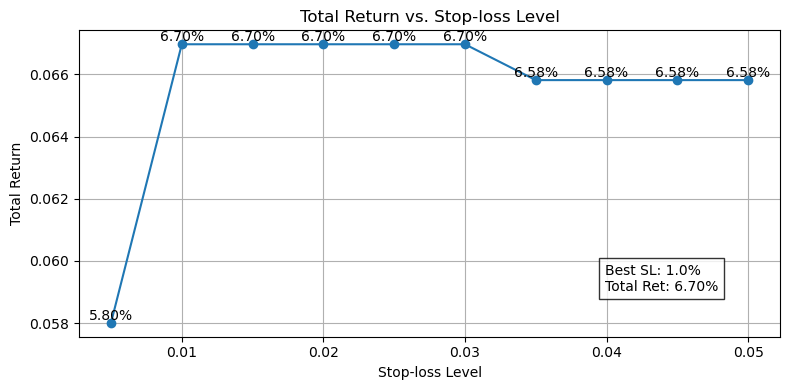

In [ ]:
#筛选止损

# --- 1. 基本配置 ---
start, end = '2024-09-01', '2025-05-20'
symbols   = {'Short':'236a.jp', 'Long':'2561.jp'}
durations = {'Short':8.2, 'Long':10.85}

# 拉信号和价格
signals = fetch_jgb_yields(start, end, window=30)
prices  = fetch_etf_prices(symbols, start.replace('-',''), end.replace('-',''))

# --- 2. 参数扫描 ---
results = []
for sl in np.arange(0.005, 0.051, 0.005):
    # 用 strat4，这里需要把 strat4 包装成 position_fn
    position_fn = lambda s,p,sl=sl: strat4(s, p, durations, stop_loss=sl)
    bt = run_backtest(signals, prices, durations, position_fn)

    # 计算指标
    total_ret = bt['Cumulative'].iloc[-1] - 1
    mdd       = max_drawdown(bt['Cumulative'])
    win_rate, pl_ratio = analyze_trades(bt)

    results.append({
        'stop_loss':   sl,
        'total_return':total_ret,
        'max_drawdown':mdd,
        'win_rate':    win_rate,
        'pl_ratio':    pl_ratio
    })

res_df = pd.DataFrame(results)

# --- 3. 输出表格 ---
print("\nStop-loss Scan Results:")
print(res_df.to_string(index=False))

# --- 4. 可视化：Total Return vs Stop-loss Level ---
plt.figure(figsize=(8,4))
plt.plot(res_df['stop_loss'], res_df['total_return'], marker='o', linestyle='-')
for sl, tr in zip(res_df['stop_loss'], res_df['total_return']):
    plt.text(sl, tr, f"{tr:.2%}", ha='center', va='bottom')

best = res_df.loc[res_df['total_return'].idxmax()]
plt.text(0.75, 0.15,
         f"Best SL: {best.stop_loss:.1%}\nTotal Ret: {best.total_return:.2%}",
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.title('Total Return vs. Stop-loss Level')
plt.xlabel('Stop-loss Level')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
"""
通过累加 StrategyRet 计算每笔交易的真实收益率：
    entry_date, exit_date, return, win (1=盈利, 0=亏损)
bt: 包含 ['Position','StrategyRet'] 的 DataFrame
"""
def extract_trades(bt: pd.DataFrame) -> pd.DataFrame:
    """
    通过累加 StrategyRet 计算每笔交易的真实收益率：
      entry_date, exit_date, return, win (1=盈利, 0=亏损)
    bt: 包含 ['Position','StrategyRet'] 的 DataFrame
    """
    trades = []
    pos = 0
    entry_date = None

    # 遍历每一天
    for date, row in bt.iterrows():
        # 开仓
        if pos == 0 and row['Position'] != 0:
            pos = row['Position']
            entry_date = date

        # 平仓
        elif pos != 0 and row['Position'] == 0:
            exit_date = date
            # 真实回报 = 这笔交易期间 StrategyRet 的累积乘积减 1
            period = bt.loc[entry_date:exit_date, 'StrategyRet'] + 1
            ret = period.prod() - 1
            trades.append({
                'entry_date': entry_date,
                'exit_date':  exit_date,
                'return':     ret,
                'win':        int(ret > 0)
            })
            pos = 0
            entry_date = None

    # 期末强制平仓
    if pos != 0 and entry_date is not None:
        exit_date = bt.index[-1]
        period = bt.loc[entry_date:exit_date, 'StrategyRet'] + 1
        ret = period.prod() - 1
        trades.append({
            'entry_date': entry_date,
            'exit_date':  exit_date,
            'return':     ret,
            'win':        int(ret > 0)
        })

    return pd.DataFrame(trades)

# —— 使用示例 ——  
trade_df = extract_trades(bt)  
print("交易明细：")  
print(trade_df.to_string(index=False))  
win_rate = trade_df['win'].mean()  
print(f"\n重新计算胜率：{win_rate:.2%}")  
# 计算盈亏比（平均盈利 / 平均亏损）  
wins    = trade_df.loc[trade_df['win']==1, 'return']  
losses  = trade_df.loc[trade_df['win']==0, 'return']  
# 如果没有亏损或没有盈利，要做边界处理  
if not wins.empty and not losses.empty:  
    pl_ratio = wins.mean() / -losses.mean()  
elif wins.empty:  
    pl_ratio = 0.0  
else:  
    pl_ratio = float('inf')

print(f"Win Rate:    {win_rate:.2%}")  
print(f"P/L Ratio:   {pl_ratio:.2f}")  


交易明细：
entry_date  exit_date    return  win
2024-11-01 2024-11-05  0.003077    1
2024-11-13 2024-12-02  0.003378    1
2024-12-12 2024-12-16  0.003070    1
2024-12-17 2024-12-18 -0.000126    0
2024-12-19 2024-12-20 -0.000377    0
2024-12-24 2025-01-30  0.008474    1
2025-02-06 2025-02-12  0.003852    1
2025-02-13 2025-02-25  0.003629    1
2025-02-28 2025-03-03  0.003621    1
2025-03-05 2025-03-25  0.004146    1
2025-03-31 2025-04-01  0.003258    1
2025-04-04 2025-04-22  0.015483    1

重新计算胜率：83.33%
Win Rate:    83.33%
P/L Ratio:   20.66


In [ ]:
# 日本交易所代码要加 .T
symbols = ["2621.T", "2856.T"]

# 拉取最近 7 天的 1 分钟数据（yfinance 对分钟线最多支持过去 7 天）
df = yf.download(
    tickers=symbols,
    period="7d",
    interval="1m",
    group_by='ticker',  # 分组存储，方便后面切片
    progress=False
)

YF.download() has changed argument auto_adjust default to True



2 Failed downloads:
['2621.T', '2856.T']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [ ]:
price_cols = ["Open", "High", "Low","Close"]

# 遍历每只 ETF
df_1 = df.ffill(axis=0).bfill(axis=0)



print(df_1["2856.T"].isna().sum())  # 检查剩余 NaN 数量

Price
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
df_1.tail(50)

Ticker                     2621.T                                   \
Price                        Open    High     Low   Close   Volume   
Datetime                                                             
2025-05-26 05:23:00+00:00  1061.0  1061.0  1061.0  1061.0    230.0   
2025-05-26 05:24:00+00:00  1061.0  1061.0  1061.0  1061.0   3589.0   
2025-05-26 05:26:00+00:00  1061.0  1061.0  1061.0  1061.0     30.0   
2025-05-26 05:30:00+00:00  1062.0  1062.0  1061.0  1061.0   4713.0   
2025-05-26 05:32:00+00:00  1062.0  1062.0  1062.0  1062.0      7.0   
2025-05-26 05:33:00+00:00  1062.0  1062.0  1062.0  1062.0      2.0   
2025-05-26 05:34:00+00:00  1062.0  1062.0  1061.0  1061.0    104.0   
2025-05-26 05:37:00+00:00  1062.0  1062.0  1061.0  1061.0   1002.0   
2025-05-26 05:38:00+00:00  1062.0  1062.0  1062.0  1062.0     18.0   
2025-05-26 05:39:00+00:00  1062.0  1062.0  1062.0  1062.0    100.0   
2025-05-26 05:40:00+00:00  1062.0  1062.0  1062.0  1062.0      1.0   
2025-05-26 05:41:00+00:00  1061.0  1062.0  1061.0  1062.0    310.0   
2025-05-26 05:42:00+00:00  1062.0  1062.0  1062.0  1062.0   4750.0   
2025-05-26 05:43:00+00:00  1062.0  1062.0  1062.0  1062.0    148.0   
2025-05-26 05:44:00+00:00  1062.0  1062.0  1062.0  1062.0   3070.0   
2025-05-26 05:45:00+00:00  1062.0  1062.0  1062.0  1062.0     10.0   
2025-05-26 05:46:00+00:00  1062.0  1062.0  1062.0  1062.0     32.0   
2025-05-26 05:47:00+00:00  1062.0  1062.0  1062.0  1062.0      6.0   
2025-05-26 05:49:00+00:00  1062.0  1062.0  1062.0  1062.0     79.0   
2025-05-26 05:50:00+00:00  1062.0  1062.0  1062.0  1062.0      1.0   
2025-05-26 05:51:00+00:00  1062.0  1062.0  1062.0  1062.0      1.0   
2025-05-26 05:52:00+00:00  1061.0  1062.0  1061.0  1062.0    351.0   
2025-05-26 05:53:00+00:00  1062.0  1062.0  1062.0  1062.0    196.0   
2025-05-26 05:54:00+00:00  1061.0  1061.0  1061.0  1061.0  13861.0   
2025-05-26 05:55:00+00:00  1061.0  1061.0  1060.0  1060.0  15000.0   
2025-05-26 05:56:00+00:00  1061.0  1061.0  1060.0  1061.0   5300.0   
2025-05-26 05:57:00+00:00  1062.0  1062.0  1062.0  1062.0    220.0   
2025-05-26 05:58:00+00:00  1062.0  1062.0  1061.0  1061.0     22.0   
2025-05-26 05:59:00+00:00  1062.0  1062.0  1061.0  1061.0    711.0   
2025-05-26 06:00:00+00:00  1062.0  1062.0  1061.0  1061.0   1052.0   
2025-05-26 06:01:00+00:00  1062.0  1062.0  1062.0  1062.0    944.0   
2025-05-26 06:02:00+00:00  1062.0  1062.0  1062.0  1062.0      3.0   
2025-05-26 06:03:00+00:00  1062.0  1062.0  1062.0  1062.0     21.0   
2025-05-26 06:05:00+00:00  1062.0  1062.0  1062.0  1062.0      1.0   
2025-05-26 06:06:00+00:00  1062.0  1062.0  1062.0  1062.0    101.0   
2025-05-26 06:07:00+00:00  1062.0  1062.0  1062.0  1062.0    100.0   
2025-05-26 06:08:00+00:00  1061.0  1061.0  1061.0  1061.0     11.0   
2025-05-26 06:09:00+00:00  1062.0  1062.0  1062.0  1062.0     17.0   
2025-05-26 06:10:00+00:00  1062.0  1062.0  1061.0  1061.0    101.0   
2025-05-26 06:11:00+00:00  1061.0  1062.0  1061.0  1062.0    201.0   
2025-05-26 06:12:00+00:00  1062.0  1062.0  1062.0  1062.0     24.0   
2025-05-26 06:13:00+00:00  1061.0  1061.0  1061.0  1061.0   1129.0   
2025-05-26 06:14:00+00:00  1061.0  1061.0  1061.0  1061.0      4.0   
2025-05-26 06:15:00+00:00  1061.0  1061.0  1061.0  1061.0    110.0   
2025-05-26 06:17:00+00:00  1061.0  1061.0  1061.0  1061.0    260.0   
2025-05-26 06:18:00+00:00  1061.0  1061.0  1061.0  1061.0      2.0   
2025-05-26 06:19:00+00:00  1061.0  1061.0  1061.0  1061.0    142.0   
2025-05-26 06:20:00+00:00  1061.0  1061.0  1061.0  1061.0      9.0   
2025-05-26 06:23:00+00:00  1061.0  1061.0  1061.0  1061.0      1.0   
2025-05-26 06:24:00+00:00  1061.0  1061.0  1061.0  1061.0    319.0   

Ticker                         2856.T                                      \
Price                            Open        High         Low       Close   
Datetime                                                                    
2025-05-26 05:23:00+00:00  680.000000  680.000000  680.000